In [1]:
# Using SWAN release 99
# pip install --user particle tabulate tqdm pickle awkward

In [2]:
import sys
import uproot
import uproot_methods
import numpy as np
import matplotlib.pyplot as plt 
import awkward
import pickle
import os
from tqdm.notebook import tqdm
from os.path import splitext,exists
from particle import Particle
from itertools import chain
from pprint import pprint

In [3]:
pileup = 50 
proton_xi_res = 0.02 # proton resolution
xi_min = 0.015 # min xi acceptance for pileup
xi_max = 0.2  # max xi acceptance for pileup
p_double = 8.8E-5 # probability of having a double tag pileup event (central-diffractive or single-diffractive x2)
p_single = 0.015 # probability of having a single tag pileup event (single-diffractive x2)


def addPileup(events,pileup,proton_xi_res,xi_min,xi_max,p_single,p_double,no_empty=False):
    # in case of no_empty, reset the xi jagged arrays 
    if len(events) == 0:
        print("Test run: running with 1M events")
        n_events = 1000000
        events["xi_pos"] = []
        events["xi_neg"] = []
    else:
        n_events=len(events["Electron_size"])

    if no_empty:
        events["xi_pos"] = []
        events["xi_neg"] = []
    for i in range(n_events):
        events["xi_pos"].append([])
        events["xi_neg"].append([])
        puEvents = np.random.poisson(pileup)
        first_round = True
        while (( ((len(events["xi_pos"][i]) < 1) | (len(events["xi_neg"][i]) < 1)) & no_empty) | ((not no_empty) & first_round)):
            for j in range(puEvents):
                tag_rng = np.random.uniform()
                if tag_rng <= p_double:
                    events["xi_pos"][i].append(xi_min *np.power( xi_max/xi_min, np.random.uniform())*np.random.normal(1,proton_xi_res)) # Assign a proton with xi1 sample from dsigma/dxi ~ 1/xi, smeared.
                    events["xi_neg"][i].append(xi_min *np.power( xi_max/xi_min, np.random.uniform())*np.random.normal(1,proton_xi_res)) # Assign a proton with xi1 sample from dsigma/dxi ~ 1/xi, smeared.
                elif (tag_rng > p_double) & (tag_rng <= p_double+p_single):
                    events["xi_pos"][i].append(xi_min *np.power( xi_max/xi_min, np.random.uniform())*np.random.normal(1,proton_xi_res)) # Assign a proton with xi1 sample from dsigma/dxi ~ 1/xi, smeared.
                elif (tag_rng > p_double+p_single) & (tag_rng <= p_double+2*p_single):
                    events["xi_neg"][i].append(xi_min *np.power( xi_max/xi_min, np.random.uniform())*np.random.normal(1,proton_xi_res)) # Assign a proton with xi1 sample from dsigma/dxi ~ 1/xi, smeared.        
            first_round = False
    events["xi_pos"] = awkward.JaggedArray.fromiter(events["xi_pos"])
    events["xi_neg"] = awkward.JaggedArray.fromiter(events["xi_neg"])
    events["xi_pos_size"] = np.array([len(i) for i in events["xi_pos"]])
    events["xi_neg_size"] = np.array([len(i) for i in events["xi_neg"]])

In [4]:
# Prepare dataset as signal or background
def prepDelphesDataset(isSignal=True, isTtbar=False, filename="", addPU = True,verbose=False):
    computeDecayType=False
    #print("Loading file:",filename)
    file = uproot.open(filename)
    tree = file["Delphes"]
    # Pick only the needed branches
    branchSelection = [
        "Particle.PID","Particle.Status","Particle.M1","Particle.Px","Particle.Py","Particle.Pz","Particle.E",
        "Electron_size","Muon_size","MissingET.MET","Electron.PT","Muon.PT","Electron.Eta","Electron.Phi","Muon.Eta",
        "Muon.Phi","MissingET.Phi","Jet.BTag","Jet.PT","Jet.Eta","Jet.Phi","Jet.Mass"
                      ]
    events = tree.arrays(branchSelection,namedecode="utf-8")
    events["BJets_size"] = np.array([np.sum(i) for i in (events["Jet.BTag"] == True)])
    events["NonBJets_size"] = np.array([np.sum(i) for i in (events["Jet.BTag"] == False)])
    
    n_events=len(events["Particle.PID"]) # n_events (updated along the way)
    initial_n_events=len(events["Particle.PID"]) # initial n_events
    if verbose:
        print("Analyzing ",initial_n_events,"events...")
    
    if isTtbar | isSignal:
            #print("Preparing ttbar variables...")
            # Select the gen level tops
            gen_top1_sel = (events["Particle.PID"] == 6) & ((events["Particle.Status"] == 123) | (events["Particle.Status"] == 124) | (events["Particle.Status"] == 22))
            gen_top2_sel = (events["Particle.PID"] == -6 ) & ((events["Particle.Status"] == 123) | (events["Particle.Status"] == 124) | (events["Particle.Status"] == 22))

            before_n = len(events["Particle.PID"])
            # Remove events with more than one gen ttbar (apparently it can happen)
            good_genTops = [len(i) == 1 and len(j) == 1 for i,j in zip(events["Particle.Px"][gen_top1_sel],events["Particle.Px"][gen_top2_sel])]
            for key in events:
                    events[key] = events[key][good_genTops]
            n_events=len(events["Particle.PID"])
            after_n = len(events["Particle.PID"])
            if verbose:
                print("Removed {}% of the events because of weird gen ttbar system".format(100*(before_n-after_n)/initial_n_events))

            gen_top1_sel = (events["Particle.PID"] == 6) & ((events["Particle.Status"] == 123) | (events["Particle.Status"] == 124) | (events["Particle.Status"] == 22))
            gen_top2_sel = (events["Particle.PID"] == -6 ) & ((events["Particle.Status"] == 123) | (events["Particle.Status"] == 124) | (events["Particle.Status"] == 22))

            events["gen_top1"] = uproot_methods.TLorentzVectorArray.from_cartesian(events["Particle.Px"][gen_top1_sel],events["Particle.Py"][gen_top1_sel],events["Particle.Pz"][gen_top1_sel],events["Particle.E"][gen_top1_sel]).flatten()
            events["gen_top2"] = uproot_methods.TLorentzVectorArray.from_cartesian(events["Particle.Px"][gen_top2_sel],events["Particle.Py"][gen_top2_sel],events["Particle.Pz"][gen_top2_sel],events["Particle.E"][gen_top2_sel]).flatten()
            events["gen_m_ttbar"] = (events["gen_top1"]+events["gen_top2"]).mass
            if verbose:
                print("Done.")
            if computeDecayType:
                decayFilename = splitext(filename)[0]+"_decayChannel.npy"
                if exists(decayFilename):
                    #print("Loading decay channels from",decayFilename)
                    events["decay_channel"] = np.load(decayFilename,allow_pickle='TRUE')
                    #print("Done.")
                else:
                    print("Computing ttbar decay type... this will take a while")
                    # Machinery to reconstruct the decay type
                    top_decay = []
                    for event_n in range(n_events):
                        top_decay.append([0,0])
                        mask = []
                        for mom_n in (events["Particle.M1"])[event_n]:
                            if mom_n >= 0:
                                mask.append(events["Particle.PID"][event_n][mom_n] == 24) 
                            else:
                                mask.append(True)

                        requirement = (mask & (events["Particle.PID"] != 24)[event_n] & (events["Particle.M1"] > 0)[event_n])
                        for top_decay_PID in events["Particle.PID"][event_n][requirement]:
                            if top_decay_PID != 22:
                                if top_decay_PID > 0:
                                    top_decay[event_n][0] += top_decay_PID * 100
                                else:
                                    top_decay[event_n][0] += -top_decay_PID
                    print("I'm halfway through")
                    for event_n in range(n_events):
                        mask = []
                        for mom_n in (events["Particle.M1"])[event_n]:
                            if mom_n >= 0:
                                mask.append(events["Particle.PID"][event_n][mom_n] == -24) 
                            else:
                                mask.append(True)

                        requirement = (mask & (events["Particle.PID"] != -24)[event_n] & (events["Particle.M1"] > 0)[event_n])
                        for top_decay_PID in events["Particle.PID"][event_n][requirement]:
                            if top_decay_PID != 22:
                                if top_decay_PID > 0:
                                    top_decay[event_n][1] += top_decay_PID * 100
                                else:
                                    top_decay[event_n][1] += -top_decay_PID
                    # Print decay fractions
                    n_lep = 0
                    n_semilep = 0
                    n_had = 0
                    decay_channel=[]
                    for event_n in range(n_events):
                        if top_decay[event_n][0] > 1000 and top_decay[event_n][1] > 1000:
                            decay_channel.append("lep")
                        elif top_decay[event_n][0] > 1000 or top_decay[event_n][1] > 1000:
                            decay_channel.append("semilep")
                        else:
                            decay_channel.append("had")
                    events["decay_channel"] = np.array(decay_channel)
                    print("Done.")
                    np.save(decayFilename, events["decay_channel"])
                    print("Saved decay channel in",decayFilename)
                n_lep = np.count_nonzero(events["decay_channel"] == "lep")
                n_semilep = np.count_nonzero(events["decay_channel"] == "semilep")
                n_had = np.count_nonzero(events["decay_channel"] == "had") 
                print("\tFully leptonic fraction:",n_lep*100/n_events,"%")
                print("\tSemileptonic fraction:",n_semilep*100/n_events,"%")
                print("\tHadronic fraction:",n_had*100/n_events,"%")
            
    if isSignal:
        if verbose:
            print("Creating gen variables...")
        # Reconstruct the gen level xi
        gen_P_pos_sel = (events["Particle.PID"] == 2212) & (events["Particle.Pz"] > 3000) & (events["Particle.Status"] == 1)
        events["gen_xi_pos"] = 1 - events["Particle.E"][gen_P_pos_sel]/7000.
        gen_P_neg_sel = (events["Particle.PID"] == 2212) & (events["Particle.Pz"] < -3000) & (events["Particle.Status"] == 1)
        events["gen_xi_neg"] = 1 - np.abs(events["Particle.E"][gen_P_neg_sel]/7000.)

        # Find events with out-of-range xi values and remove them
        counter = 0
        not_weird_xi = []
        for i in range(len(events["Particle.Pz"][gen_P_pos_sel])):
            if len(events["gen_xi_pos"][i]) > 0 and len(events["gen_xi_neg"][i]) > 0:
                if events["gen_xi_pos"][i] > 0.2 or events["gen_xi_pos"][i] < 0.015 or events["gen_xi_neg"][i] > 0.2 or events["gen_xi_neg"][i] < 0.015:
                    counter += 1
                    not_weird_xi.append(False)
                else:
                    not_weird_xi.append(True)
            else:
                counter += 1
                not_weird_xi.append(False)
        if verbose:
            print("Found {:.1f}% weird xi events".format(counter/n_events*100))
        for key in events:
                events[key] = events[key][not_weird_xi]
        n_events=len(events["Particle.PID"])
        events["gen_xi_pos"] = np.array(events["gen_xi_pos"].flatten())
        events["gen_xi_neg"] = np.array(events["gen_xi_neg"].flatten())
        # Compute the central mass and rapidity from the gen protons
        events["gen_m_protons"] = 14000 * np.sqrt(events["gen_xi_pos"] * events["gen_xi_neg"])
        events["gen_y_protons"] = 0.5 * np.log(events["gen_xi_pos"] / events["gen_xi_neg"])
        # Compute xi with smearing
        events["xi_pos"] = []
        events["xi_neg"] = []
        if verbose:
            print("Done.")
            print("Smearing gen protons...")
        for i in range(n_events):
            events["xi_pos"].append([events["gen_xi_pos"][i] * np.random.normal(1,proton_xi_res)])
            events["xi_neg"].append([events["gen_xi_neg"][i] * np.random.normal(1,proton_xi_res)])
        if verbose:
            print("Done.")
    else:
        events["xi_pos"] = []
        events["xi_neg"] = []
    if addPU:
        if verbose:
            print("Adding pileup protons...")
        # addPileup(events,pileup,proton_xi_res,xi_min,xi_max,p_single,p_double)  
        # Force pileup into each BG event (not to waste good MC)
        addPileup(events,pileup,proton_xi_res,xi_min,xi_max,p_single,p_double,True)        
        if verbose:
            print("Done.")    
    events["xi_pos"] = awkward.JaggedArray.fromiter(events["xi_pos"])
    events["xi_neg"] = awkward.JaggedArray.fromiter(events["xi_neg"])
    events["xi_pos_size"] = np.array([len(i) for i in events["xi_pos"]])
    events["xi_neg_size"] = np.array([len(i) for i in events["xi_neg"]])
    
    usefulVars = ["xi_pos_size","xi_neg_size","xi_pos","xi_neg","decay_channel",
                  "gen_m_ttbar","gen_m_protons","gen_top1","gen_top2","Electron_size","Muon_size","BJets_size",
                  "NonBJets_size","MissingET.MET","Electron.PT","Muon.PT","Electron.Eta","Electron.Phi",
                  "Muon.Eta","Muon.Phi","MissingET.Phi","Jet.BTag","Jet.PT","Jet.Eta","Jet.Phi","Jet.Mass",
                 ]
    for key in list(events):
        if key not in usefulVars:
            del events[key]
    #print("Finished!\n")
    return events

In [18]:
# produce weight for number of events having at least one proton per arm in the final state in an example BG sample (when not adding pileup to all evenprepDelphesDatasetphesDatasetttbar_ds = prepDelphesDataset(isSignal=False, isTtbar=True, filename=, addPU = True,verbose=False)
test_events = {}
addPileup(test_events,pileup,proton_xi_res,xi_min,xi_max,p_single,p_double)  
n_events = len(test_events["xi_pos_size"])
n_mthan1ProtPerSide = np.sum((test_events["xi_pos_size"] >= 1) & (test_events["xi_neg_size"] >= 1))
protons_in_pps_weight = n_mthan1ProtPerSide / n_events
print("Weight factor =",protons_in_pps_weight)

NameError: name 'addPileup' is not defined

In [5]:
protons_in_pps_weight = 0.28187

In [6]:
def plotWithRange(variable,nbins,xmin,xmax,xlabel="",histlabel="",axis=None,scalefactor=1,logscale=False,normalize=False):
    binWidth=(float)(xmax-xmin)/nbins
    ax = axis
    if axis==None:
        fig,ax = plt.subplots(1,figsize=(15,10))
    if normalize:
        scalefactor = 1. / len(variable)
    binEdges=[xmin+i*binWidth for i in range(nbins+1)]
    y, bin_edges,patches = ax.hist(variable, bins=binEdges,histtype="step",label=histlabel,weights = np.ones_like(variable) * scalefactor)
    plt.xlabel(xlabel,fontsize=20)
    plt.xlim([xmin,xmax])
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    ax.errorbar(
        bin_centers,
        y,
        yerr = (y*scalefactor)**0.5,
        marker = '.',
        linestyle = 'None',
        drawstyle = 'steps-mid',
        color=patches[0].get_edgecolor()
    )
    if logscale:
        plt.yscale("log")
    if histlabel != "":
        plt.legend(fontsize=20)
    return ax

In [7]:
def scanCut(signal_ds,background_ds,f_cut,par_start_stop_step,x_label=""):
    n_signal = len(signal_ds[list(signal_ds.keys())[0]])
    n_background = len(background_ds[list(background_ds.keys())[0]])
    cut_values = []
    signal_fractions = []
    background_fractions = []
    signal_over_sqrtb = []
    for par in np.arange(par_start_stop_step[0],par_start_stop_step[1]+par_start_stop_step[2],par_start_stop_step[2]):
        cut_values.append(par)
        sig_pass = sum(f_cut(signal_ds,par))
        bg_pass = sum(f_cut(background_ds,par))
        signal_fractions.append(sig_pass/n_signal)
        background_fractions.append(bg_pass/n_background)
        if bg_pass == 0:
            print("No BG events passed for par = ",par,"\nUsing 0.0001 as symbolic value")
            bg_pass = 0.0001
        signal_over_sqrtb.append((sig_pass)/np.sqrt(bg_pass))
    fig,ax = plt.subplots(1,figsize=(15,10))
    aux_arr = np.abs(0.9-np.array(signal_fractions))
    sig_eff_90 = min(aux_arr)
    sig_eff_90_index = list(aux_arr).index(sig_eff_90)
    max_sbr = max(signal_over_sqrtb)
    max_index = signal_over_sqrtb.index(max_sbr)
    print("Maximum signal over square root of background:", max_sbr, "for cut value:",cut_values[max_index],"(sig. eff.:",100.*signal_fractions[max_index],"%, bg. rej.",100.*(1-background_fractions[max_index]),"%)")
    print("Closest point to 90% signal efficiency at cut value:",cut_values[sig_eff_90_index],"(sig. eff.:",100.*signal_fractions[sig_eff_90_index],"%, bg. rej.",100.*(1-background_fractions[sig_eff_90_index]),"%)")
    ax.plot(cut_values,signal_fractions, label="Signal efficiency")
    ax.plot(cut_values,1 - np.array(background_fractions), label="Background rejection")
    ax.plot(cut_values,np.array(signal_over_sqrtb)/max_sbr, label=r"$(S/\sqrt{B})/(S/\sqrt{B})_{max}$")  
    plt.xlabel(x_label,fontsize=20)
    plt.legend(fontsize=20)

In [8]:
# Parallelize preparation and selection of samples
import multiprocessing as mp

# Aux functions
def prepareSample(isSignal=True,isTtbar=False,addPU = True,filenameTemplate="",sampleID=-1,force=False):
    if not isSignal:
        sampleName = filenameTemplate.format("{:02d}").format(sampleID)
    else:
        sampleName = filenameTemplate.format(sampleID)
    if os.path.isfile(sampleName):
        if os.path.isfile(sampleName.replace('.root','_skim.pickle')) and (not force):
            return
        events = prepDelphesDataset(isSignal,isTtbar,sampleName,addPU)
        if (not isSignal) and addPU:
            addPileup(events,pileup,proton_xi_res,xi_min,xi_max,p_single,p_double,True)        
        with open(sampleName.replace('.root','_skim.pickle'),'wb') as handle:
            pickle.dump(events,handle,protocol=pickle.HIGHEST_PROTOCOL)
    else:
        print("Skipping file:",sampleName)
def prepareSample_unrollArgs(args):
    """Need to do this to work well with tqdm+mp"""
    return prepareSample(*args)

def prepareSamples(isSignal=True,isTtbar=False,addPU = True,filenameTemplate="",sampleIDs=[],sampleName="",force=False):
    """Prepare all the samples in the sampleID list. Parallelize on all cores available"""
    arguments = [[isSignal,isTtbar,addPU,filenameTemplate,sampleID,force] for sampleID in sampleIDs]
    with mp.Pool(8) as pool:
        results = list(tqdm(pool.imap(prepareSample_unrollArgs,arguments),total=len(arguments),desc=sampleName))
        
def runSelectionOnSample(select,filenameTemplate="",sampleID=-1,suffix=""):
    sampleName = filenameTemplate.format(sampleID)
    if not os.path.isfile(sampleName):
        sampleName = filenameTemplate.format("{:02d}").format(sampleID)
    if not os.path.isfile(sampleName):
        print("Skipping sampleID:",sampleID)
        return 0,0
    
    n_before = 0
    n_after = 0
    with open(sampleName,'rb') as handle:
        events = pickle.load(handle)
        n_before = len(events["xi_pos"])
        if n_before != 0:
            events_after = select(events)
        else:
            events_after = events
        n_after = len(events_after["xi_pos"])
        events_after["n_before"] = n_before
    with open(sampleName.replace('.pickle',suffix+'.pickle'),'wb') as handle:
        pickle.dump(events_after,handle,protocol=pickle.HIGHEST_PROTOCOL)
    return n_before,n_after
def runSelectionOnSample_unrollArgs(args):
    return runSelectionOnSample(*args)

def runSelection(select,filenameTemplate="",sampleIDs=[],suffix="",sampleName=""):
    """Run selection in the sampleID list. Parallelize on all cores available"""
    arguments = [[select,filenameTemplate,sampleID,suffix] for sampleID in sampleIDs]
    with mp.Pool(8) as pool:
        results = list(tqdm(pool.imap(runSelectionOnSample_unrollArgs,arguments),total=len(arguments),desc=sampleName))
    return tuple([sum(x) for x in zip(*results)])

def loadEvents(filenameTemplate="",sampleIDs=[],sampleName=""):
    events = {}
    for sampleID in tqdm(sampleIDs,desc=sampleName):
        sampleName = filenameTemplate.format(sampleID)
        if not os.path.isfile(sampleName):
            sampleName = filenameTemplate.format("{:02d}").format(sampleID)
        if not os.path.isfile(sampleName):
            print("Skipping sampleID:",sampleID)
            continue
        with open(sampleName,'rb') as handle:
                for k,v in pickle.load(handle).items():
                    if k in events.keys():
                        if type(v) is np.ndarray:
                            events[k] = np.append(events[k],v)
                        elif type(v) is awkward.JaggedArray:
                            events[k] = events[k].concatenate([v])
                        elif type(v) is uproot_methods.TLorentzVectorArray:
                            events[k] = [v for v in chain(events[k],v)]
                        elif type(v) is int:
                            events[k] += v 
                        else:
                            events[k].append(v)
                    else:
                        events[k] = v  
    return events

def passedFraction(filenameTemplate="",sampleIDs=[],sampleName=""):
    n_before = 0
    n_after = 0
    for sampleID in tqdm(sampleIDs,desc=sampleName):
        sampleName = filenameTemplate.format(sampleID)
        if not os.path.isfile(sampleName):
            sampleName = filenameTemplate.format("{:02d}").format(sampleID)
        if not os.path.isfile(sampleName):
            print("Skipping sampleID:",sampleID)
            continue
        with open(sampleName,'rb') as handle:
                events = pickle.load(handle)
                n_before += events["n_before"]
                n_after += len(events['xi_pos'])
    return n_before, n_after

In [9]:
# Load MC samples from Excel "DB"

from openpyxl import load_workbook
simLogFile = '../SimLog/SimLog.xlsx'
signal_samples_wb = load_workbook(simLogFile)['Signal']
background_samples_wb = load_workbook(simLogFile)['Background']

# Get the couplingSet -> sample map for signal
signalSampleDict = {}
for row in signal_samples_wb.iter_rows(min_row=2):
    couplingSet = tuple(
        [cell.value for cell in row[0:6]]
    )
    if any(couplingSet):
        signalSampleDict[couplingSet] = range(row[6].value,row[7].value+1)

# Get the name -> sample map for bg
bgSampleDict = {}
for row in background_samples_wb.iter_rows(min_row=2):
    name = row[0].value
    bgSampleDict[name] = range(row[1].value,row[2].value+1)

# Utility to produce the sample name from the coupling set
def nameFromCouplingSet(couplingSet):
    name = ""
    for i in range(len(couplingSet)):
        if couplingSet[i] != 0:
            if len(name) != 0:
                name += " & "
            name += "Xi" + str(i+1) + "=" + str(couplingSet[i])
    return name

# Utility to produce the coupling set from the sample name
def couplingSetFromName(name):
    couplings = []
    for i in range(6):
        couplings.append(0)
    for couplingAndValue in name.split(sep=' & '):
        couplingName,couplingValue = couplingAndValue.split(sep='=')
        couplings[int(couplingName.replace('Xi',''))-1] = float(couplingValue)
    return tuple(couplings)

In [60]:
signalPathTemplate = "/eos/home-a/abellora/SWAN_projects/TopPheno/FPMC_tools/DELPHES/{}/excl_anomTtbar_QED.root"
for couplingSet,sampleIDs in tqdm(signalSampleDict.items(),desc='Signal samples'):
    sampleName = nameFromCouplingSet(couplingSet)
    prepareSamples(True,True,False,signalPathTemplate,sampleIDs,sampleName=sampleName)

Signal samples:   0%|          | 0/12 [00:00<?, ?it/s]

Xi1=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi2=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi3=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi4=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi5=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi6=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi1=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Xi2=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Xi3=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Xi4=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Xi5=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Xi6=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

In [15]:
backgroundPathTemplate = "/eos/home-a/abellora/SWAN_projects/TopPheno/MadGraph/MG5_aMC_v3_1_0/{name}/Events/run_{id}/tag_1_delphes_events.root"
for name,sampleIDs in tqdm(bgSampleDict.items(),desc='Background samples'):
    if "ttbar" in name:
        prepareSamples(False,True,True,backgroundPathTemplate.format(name=name,id='{}'),sampleIDs,sampleName=name)
    else:
        prepareSamples(False,False,True,backgroundPathTemplate.format(name=name,id='{}'),sampleIDs,sampleName=name)

Background samples:   0%|          | 0/2 [00:00<?, ?it/s]

SM_ttbar:   0%|          | 0/219 [00:00<?, ?it/s]

Skipping file: /eos/home-a/abellora/SWAN_projects/TopPheno/MadGraph/MG5_aMC_v3_1_0/SM_ttbar/Events/run_103/tag_1_delphes_events.root
Skipping file: /eos/home-a/abellora/SWAN_projects/TopPheno/MadGraph/MG5_aMC_v3_1_0/SM_ttbar/Events/run_143/tag_1_delphes_events.root
Skipping file: /eos/home-a/abellora/SWAN_projects/TopPheno/MadGraph/MG5_aMC_v3_1_0/SM_ttbar/Events/run_196/tag_1_delphes_events.root


SM_WW:   0%|          | 0/46 [00:00<?, ?it/s]

Skipping file: /eos/home-a/abellora/SWAN_projects/TopPheno/MadGraph/MG5_aMC_v3_1_0/SM_WW/Events/run_11/tag_1_delphes_events.root
Skipping file: /eos/home-a/abellora/SWAN_projects/TopPheno/MadGraph/MG5_aMC_v3_1_0/SM_WW/Events/run_39/tag_1_delphes_events.root


In [10]:
# Cross sections in fb
xSecDict = {} 
signalLogTemplate = "/eos/home-a/abellora/SWAN_projects/TopPheno/FPMC_tools/LOG/{}/Summary.txt"

for couplingSet,sampleIDs in signalSampleDict.items():
    avgXsec = 0
    for id in sampleIDs:
        with open(signalLogTemplate.format(id)) as dc:
            for line in dc: 
                if line.startswith(" Cross"):
                    avgXsec += float(line.split()[2]) * 1000 #transform in fb
    avgXsec /= len(sampleIDs)
    xSecDict[nameFromCouplingSet(couplingSet)] = avgXsec
xSecDict["SM_ttbar"] = 903 * 1e+3 # https://arxiv.org/pdf/1109.1536.pdf
xSecDict["SM_WW"] = 131.3 * 1e+3 # https://arxiv.org/pdf/1408.5243.pdf

print("*********CROSS SECTIONS*********")
for k,v in xSecDict.items():
    print(k+":",v,"fb")

*********CROSS SECTIONS*********
Xi1=1e-12: 0.0943515654734445 fb
Xi2=1e-12: 0.10287160286046812 fb
Xi3=1e-12: 0.09440617857946113 fb
Xi4=1e-12: 0.1027429025072486 fb
Xi5=1e-12: 0.11522844715883726 fb
Xi6=1e-12: 0.10797201268158334 fb
Xi1=1e-11: 9.415402081171269 fb
Xi2=1e-11: 10.275937909401058 fb
Xi3=1e-11: 9.429640503654392 fb
Xi4=1e-11: 10.284184119648089 fb
Xi5=1e-11: 11.515640317376949 fb
Xi6=1e-11: 10.776681974668174 fb
SM_ttbar: 903000.0 fb
SM_WW: 131300.0 fb


In [10]:
signalPathTemplate = "/eos/home-a/abellora/SWAN_projects/TopPheno/FPMC_tools/DELPHES/{}/excl_anomTtbar_QED.root"
backgroundPathTemplate = "/eos/home-a/abellora/SWAN_projects/TopPheno/MadGraph/MG5_aMC_v3_1_0/{name}/Events/run_{id}/tag_1_delphes_events.root"

xi1_1e12 = loadEvents(signalPathTemplate.replace('.root','_skim.pickle'),sampleIDs=signalSampleDict[couplingSetFromName('Xi1=1e-12')])
xi2_1e12 = loadEvents(signalPathTemplate.replace('.root','_skim.pickle'),sampleIDs=signalSampleDict[couplingSetFromName('Xi2=1e-12')])
xi3_1e12 = loadEvents(signalPathTemplate.replace('.root','_skim.pickle'),sampleIDs=signalSampleDict[couplingSetFromName('Xi3=1e-12')])
xi4_1e12 = loadEvents(signalPathTemplate.replace('.root','_skim.pickle'),sampleIDs=signalSampleDict[couplingSetFromName('Xi4=1e-12')])
xi5_1e12 = loadEvents(signalPathTemplate.replace('.root','_skim.pickle'),sampleIDs=signalSampleDict[couplingSetFromName('Xi5=1e-12')])
xi6_1e12 = loadEvents(signalPathTemplate.replace('.root','_skim.pickle'),sampleIDs=signalSampleDict[couplingSetFromName('Xi6=1e-12')])
SM_ttbar = loadEvents(backgroundPathTemplate.format(name='SM_ttbar',id='{}').replace('.root','_skim.pickle'),sampleIDs=bgSampleDict['SM_ttbar'])

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

Skipping sampleID: 103
Skipping sampleID: 143
Skipping sampleID: 196


In [11]:
# total integrated luminosity for the study
lumi_tot = 300. # 1/fb

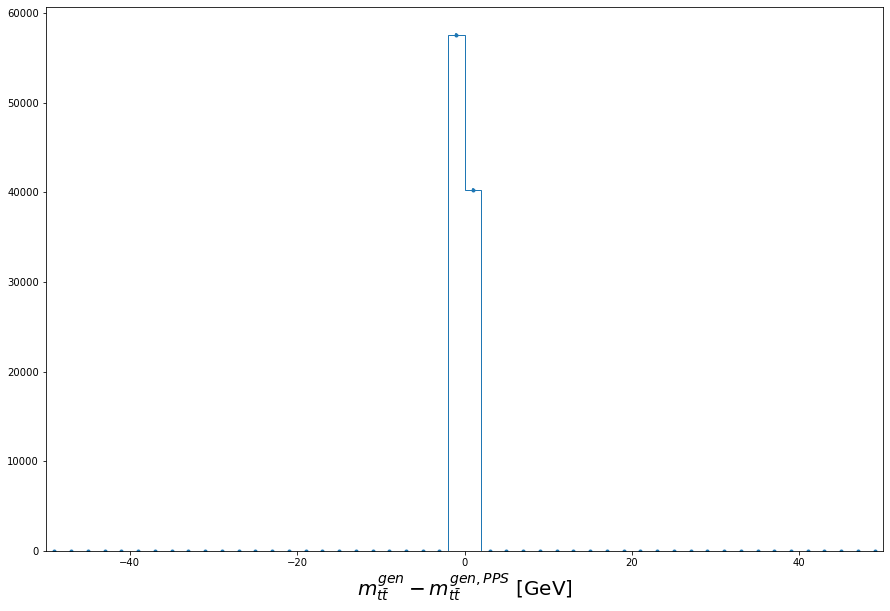

In [15]:
ax = plotWithRange(xi1_1e12["gen_m_ttbar"]-xi1_1e12["gen_m_protons"],50,-50,50,r"$m_{t\bar{t}}^{gen} - m_{t\bar{t}}^{gen,PPS}$ [GeV]")

<AxesSubplot:xlabel='$m_{t\\bar{t}}^{gen}$ [GeV]'>

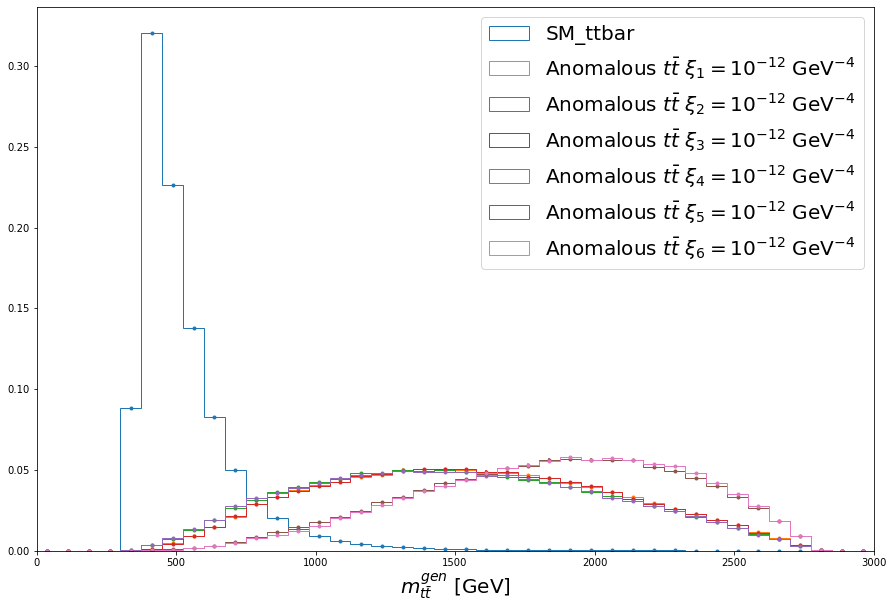

In [14]:
ax = plotWithRange(SM_ttbar["gen_m_ttbar"],40,0,3000,"","SM_ttbar",normalize=True)
plotWithRange(xi1_1e12["gen_m_ttbar"],40,0,3000,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)
plotWithRange(xi2_1e12["gen_m_ttbar"],40,0,3000,"",r"Anomalous $t\bar{t}$ $\xi_2 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)
plotWithRange(xi3_1e12["gen_m_ttbar"],40,0,3000,"",r"Anomalous $t\bar{t}$ $\xi_3 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)
plotWithRange(xi4_1e12["gen_m_ttbar"],40,0,3000,"",r"Anomalous $t\bar{t}$ $\xi_4 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)
plotWithRange(xi5_1e12["gen_m_ttbar"],40,0,3000,"",r"Anomalous $t\bar{t}$ $\xi_5 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)
plotWithRange(xi6_1e12["gen_m_ttbar"],40,0,3000,r"$m_{t\bar{t}}^{gen}$ [GeV]",r"Anomalous $t\bar{t}$ $\xi_6 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)

<AxesSubplot:xlabel='$p_{T}^{top}$ [GeV]'>

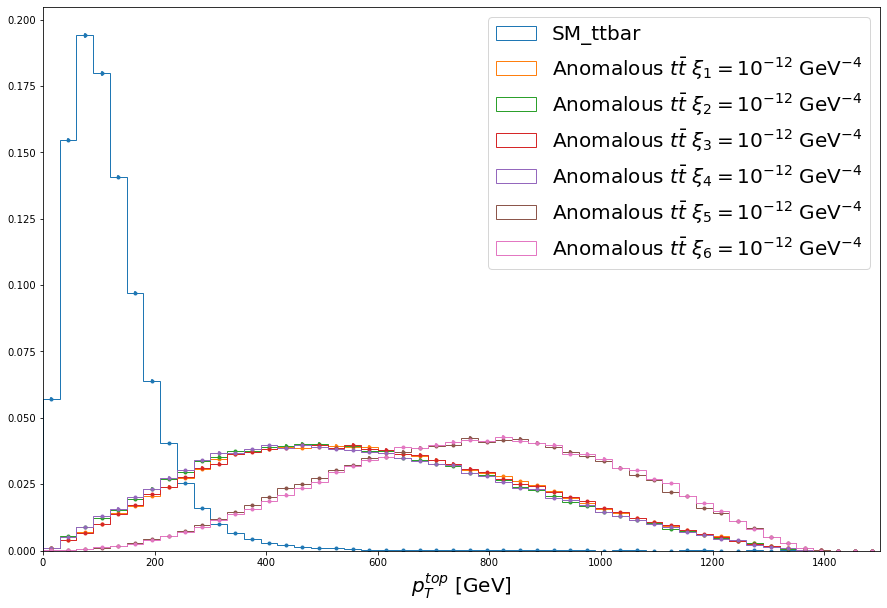

In [86]:
ax = plotWithRange([ t.pt for t in SM_ttbar["gen_top1"]],50,0,1500,r"$p_{T}^{top,gen}$ [GeV]","SM_ttbar",normalize=True)
plotWithRange([ t.pt for t in xi1_1e12["gen_top1"]],50,0,1500,r"$p_{T}^{top}$ [GeV]",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)
plotWithRange([ t.pt for t in xi2_1e12["gen_top1"]],50,0,1500,r"$p_{T}^{top}$ [GeV]",r"Anomalous $t\bar{t}$ $\xi_2 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)
plotWithRange([ t.pt for t in xi3_1e12["gen_top1"]],50,0,1500,r"$p_{T}^{top}$ [GeV]",r"Anomalous $t\bar{t}$ $\xi_3 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)
plotWithRange([ t.pt for t in xi4_1e12["gen_top1"]],50,0,1500,r"$p_{T}^{top}$ [GeV]",r"Anomalous $t\bar{t}$ $\xi_4 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)
plotWithRange([ t.pt for t in xi5_1e12["gen_top1"]],50,0,1500,r"$p_{T}^{top}$ [GeV]",r"Anomalous $t\bar{t}$ $\xi_5 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)
plotWithRange([ t.pt for t in xi6_1e12["gen_top1"]],50,0,1500,r"$p_{T}^{top}$ [GeV]",r"Anomalous $t\bar{t}$ $\xi_6 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)

In [12]:
# compute the pz of the neutrino imposing the neutrino+lepton system to have the mass of the W

def addPzToNeutrino(neutrino,lepton):
    a = ((lepton.mass**2 - (Particle.from_pdgid(24).mass*1E-3)**2)/2 - lepton.p3.x * neutrino.p3.x - lepton.p3.y * neutrino.p3.y )/lepton.energy
    b = lepton.p3.z / lepton.energy
    sqrt_delta4 = np.sqrt(np.complex(a**2 + (b**2)*(neutrino.pt**2) - neutrino.pt**2))
    nu_pz_1 = (a*b + sqrt_delta4.real )/(b**2 - 1)
    nu_pz_2 = (a*b - sqrt_delta4.real )/(b**2 - 1)
    if np.abs(nu_pz_1 - lepton.p3.z) < np.abs(nu_pz_2 - lepton.p3.z):
        neutrino = uproot_methods.TLorentzVector.from_xyzm(neutrino.p3.x,neutrino.p3.y,nu_pz_1,0)
    else:
        neutrino = uproot_methods.TLorentzVector.from_xyzm(neutrino.p3.x,neutrino.p3.y,nu_pz_2,0)
    return neutrino

In [13]:
# Analyze semileptonic channel
def semilepAnalysisPreselection(dataset,verbose=False):
    ## Preselection
    mthan1Lep_sel = (dataset["Electron_size"] > 0) | (dataset["Muon_size"] > 0)
    mthan2BJets_sel = dataset["BJets_size"] >= 2
    mthan2NonBJets_sel = dataset["NonBJets_size"] >= 2
    mthan20gevMET_sel = (dataset["MissingET.MET"] > 20).flatten()
    mthan1ProtPerSide_sel = (dataset["xi_pos_size"] >= 1) & (dataset["xi_neg_size"] >= 1)
    semilep_presel = mthan1Lep_sel & mthan2BJets_sel & mthan2NonBJets_sel & mthan20gevMET_sel & mthan1ProtPerSide_sel

    frac_passing = 1.*np.count_nonzero(semilep_presel)/len(dataset["xi_neg_size"])
    if verbose:
        print("Passing semilep preselection:", np.count_nonzero(semilep_presel),"({:.2f}%)".format(100.*frac_passing))
    for key in dataset:
        if key != 'n_before':
            dataset[key] = dataset[key][semilep_presel]

    # Reconstruct ttbar system

    dataset["Lepton"] = np.array([])
    dataset["Neutrino"] = np.array([])
    dataset["BJet_1"] = np.array([])
    dataset["BJet_2"] = np.array([])
    dataset["Jet_1"] = np.array([])
    dataset["Jet_2"] = np.array([])
    dataset["top_1"] = np.array([])
    dataset["top_2"] = np.array([])
    for i in range(len(dataset["Electron_size"])):
        
        # Choose the highest PT lepton
        max_pt_e = 0
        max_pt_e_idx = -1
        max_pt_mu = 0
        max_pt_mu_idx = -1
        if dataset["Electron_size"][i] > 0:
            max_pt_e = dataset["Electron.PT"][i][0]
        if dataset["Muon_size"][i] > 0:
            max_pt_mu = dataset["Muon.PT"][i][0]
        if max_pt_e > max_pt_mu:
            lepton = uproot_methods.TLorentzVector.from_ptetaphim(max_pt_e,dataset["Electron.Eta"][i][0],dataset["Electron.Phi"][i][0],Particle.from_pdgid(11).mass*1E-3)
        else:
            lepton = uproot_methods.TLorentzVector.from_ptetaphim(max_pt_mu,dataset["Muon.Eta"][i][0],dataset["Muon.Phi"][i][0],Particle.from_pdgid(13).mass*1E-3)
        dataset["Lepton"] = np.append(dataset["Lepton"],lepton)
        # Add the neutrino (pz obtained imposing (neutrino+lepton).mass = W.mass)
        neutrino = uproot_methods.TLorentzVector.from_ptetaphim(dataset["MissingET.MET"][i][0],0,dataset["MissingET.Phi"][i][0],0)
        neutrino = addPzToNeutrino(neutrino,lepton)
        dataset["Neutrino"] = np.append(dataset["Neutrino"],neutrino)
        # Get the two most energetic BJets
        bjets_sel = dataset["Jet.BTag"] == True
        bjet_1 = uproot_methods.TLorentzVector.from_ptetaphim(dataset["Jet.PT"][bjets_sel][i][0],dataset["Jet.Eta"][bjets_sel][i][0],dataset["Jet.Phi"][bjets_sel][i][0],dataset["Jet.Mass"][bjets_sel][i][0])
        bjet_2 = uproot_methods.TLorentzVector.from_ptetaphim(dataset["Jet.PT"][bjets_sel][i][1],dataset["Jet.Eta"][bjets_sel][i][1],dataset["Jet.Phi"][bjets_sel][i][1],dataset["Jet.Mass"][bjets_sel][i][1])
        dataset["BJet_1"] = np.append(dataset["BJet_1"],bjet_1)
        dataset["BJet_2"] = np.append(dataset["BJet_2"],bjet_2)
        # Get the two most energetic NonBJets
        jets_sel = dataset["Jet.BTag"] == False
        jet_1 = uproot_methods.TLorentzVector.from_ptetaphim(dataset["Jet.PT"][jets_sel][i][0],dataset["Jet.Eta"][jets_sel][i][0],dataset["Jet.Phi"][jets_sel][i][0],dataset["Jet.Mass"][jets_sel][i][0])
        jet_2 = uproot_methods.TLorentzVector.from_ptetaphim(dataset["Jet.PT"][jets_sel][i][1],dataset["Jet.Eta"][jets_sel][i][1],dataset["Jet.Phi"][jets_sel][i][1],dataset["Jet.Mass"][jets_sel][i][1])
        dataset["Jet_1"] = np.append(dataset["Jet_1"],jet_1)
        dataset["Jet_2"] = np.append(dataset["Jet_2"],jet_2)
        # Reconstruct the two tops (top_1 is semi-lep, top_2 is hadronic)
        # Assign b-jets based on the mass of the dijet+bjet system being close to the top mass
        if np.abs((jet_1 + jet_2 + bjet_1).mass - Particle.from_pdgid(6).mass*1E-3) < ((jet_1 + jet_2 + bjet_2).mass - Particle.from_pdgid(6).mass*1E-3):
            top_1 = neutrino + lepton + bjet_2
            top_2 = jet_1 + jet_2 + bjet_1
        else:
            top_1 = neutrino + lepton + bjet_1
            top_2 = jet_1 + jet_2 + bjet_2
        dataset["top_1"] = np.append(dataset["top_1"],top_1)
        dataset["top_2"] = np.append(dataset["top_2"],top_2)     
        
    dataset["m_ttbar"] = np.array([ttbar.mass for ttbar in dataset["Lepton"] + dataset["Neutrino"] + dataset["BJet_1"] + dataset["BJet_2"] + dataset["Jet_1"] + dataset["Jet_2"]])
    dataset["y_ttbar"] = np.array([ttbar.rapidity for ttbar in dataset["Lepton"] + dataset["Neutrino"] + dataset["BJet_1"] + dataset["BJet_2"] + dataset["Jet_1"] + dataset["Jet_2"]])
    
    # Compute mass from protons
    dataset["m_protons"] = np.array([14000 * np.sqrt(max(xi_pos) * max(xi_neg)) for xi_pos,xi_neg in zip(dataset["xi_pos"],dataset["xi_neg"])])
    # Compute rapidity from protons
    dataset["y_protons"] = np.array([0.5 * np.log(max(xi_pos) / max(xi_neg)) for xi_pos,xi_neg in zip(dataset["xi_pos"],dataset["xi_neg"])])
    
    # Compute the sum of the BJet energies
    dataset["BJet_energy_tot"] = np.array([j1.energy+j2.energy for j1,j2 in zip(dataset["BJet_1"],dataset["BJet_2"])])
    # Compute the sum of the BJet PT
    dataset["BJet_pt_tot"] = np.array([j1.pt+j2.pt for j1,j2 in zip(dataset["BJet_1"],dataset["BJet_2"])])
    # Compute the sum of the BJet acoplanarity
    dataset["BJet_acoplanarity"] = np.array([np.abs(1-(j1.phi-j2.phi)/np.pi) for j1,j2 in zip(dataset["BJet_1"],dataset["BJet_2"])])
    
    # Compute the sum of the non-BJet energies
    dataset["Jet_energy_tot"] = np.array([j1.energy+j2.energy for j1,j2 in zip(dataset["Jet_1"],dataset["Jet_2"])])
    # Compute the sum of the non-BJet PT
    dataset["Jet_pt_tot"] = np.array([j1.pt+j2.pt for j1,j2 in zip(dataset["Jet_1"],dataset["Jet_2"])])
    
    usefulVars = ["xi_pos_size","xi_neg_size","xi_pos","xi_neg","decay_channel",
                  "gen_m_ttbar","gen_m_protons","gen_top1","gen_top2","top_1","top_2","Electron_size","Muon_size","BJets_size",
                  "NonBJets_size","MissingET.MET","Electron.PT","Muon.PT","Electron.Eta","Electron.Phi",
                  "Muon.Eta","Muon.Phi","MissingET.Phi","Jet.BTag","Jet.PT","Jet.Eta","Jet.Phi","Jet.Mass","Neutrino",
                  "m_ttbar","y_ttbar","m_protons","y_protons","BJet_pt_tot","Jet_pt_tot","n_before","Lepton"
                 ]
    for key in list(dataset):
        if key not in usefulVars:
            del dataset[key]
            
    return dataset

In [91]:
signalSkimTemplate = "/eos/home-a/abellora/SWAN_projects/TopPheno/FPMC_tools/DELPHES/{}/excl_anomTtbar_QED_skim.pickle"
signalPass_presel = {}
for couplingSet,sampleIDs in tqdm(signalSampleDict.items(),desc='Signal samples'):
    sampleName = nameFromCouplingSet(couplingSet)
    signalPass_presel[couplingSet] = runSelection(semilepAnalysisPreselection,signalSkimTemplate,sampleIDs,suffix="_semilep_preselection",sampleName=sampleName)

Signal samples:   0%|          | 0/12 [00:00<?, ?it/s]

Xi1=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi2=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi3=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi4=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi5=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi6=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi1=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Xi2=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Xi3=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Xi4=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Xi5=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Xi6=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

In [92]:
backgroundPathTemplate = "/eos/home-a/abellora/SWAN_projects/TopPheno/MadGraph/MG5_aMC_v3_1_0/{name}/Events/run_{id}/tag_1_delphes_events_skim.pickle"
backgroundPass_presel = {}
 
for name,sampleIDs in tqdm(bgSampleDict.items(),desc='Background samples'):
    if "ttbar" in name:
        backgroundPass_presel[name] = runSelection(semilepAnalysisPreselection,backgroundPathTemplate.format(name=name,id='{}'),sampleIDs,suffix="_semilep_preselection",sampleName=name)
    else:
        backgroundPass_presel[name] = runSelection(semilepAnalysisPreselection,backgroundPathTemplate.format(name=name,id='{}'),sampleIDs,suffix="_semilep_preselection",sampleName=name)

Background samples:   0%|          | 0/2 [00:00<?, ?it/s]

SM_ttbar:   0%|          | 0/219 [00:00<?, ?it/s]

Skipping sampleID: 103
Skipping sampleID: 143
Skipping sampleID: 196


SM_WW:   0%|          | 0/46 [00:00<?, ?it/s]

Skipping sampleID: 11
Skipping sampleID: 39


In [14]:
signalPathTemplate = "/eos/home-a/abellora/SWAN_projects/TopPheno/FPMC_tools/DELPHES/{}/excl_anomTtbar_QED.root"
signalPass_presel = {}
backgroundPathTemplate = "/eos/home-a/abellora/SWAN_projects/TopPheno/MadGraph/MG5_aMC_v3_1_0/{name}/Events/run_{id}/tag_1_delphes_events.root"
backgroundPass_presel = {}

for couplingSet,sampleIDs in tqdm(signalSampleDict.items(),desc='Signal samples'):
    sampleName = nameFromCouplingSet(couplingSet)
    signalPass_presel[couplingSet] = passedFraction(signalPathTemplate.replace('.root','_skim_semilep_preselection.pickle'),sampleIDs=sampleIDs,sampleName=sampleName)
    
for name,sampleIDs in tqdm(bgSampleDict.items(),desc='Background samples'):
    backgroundPass_presel[name] = passedFraction(backgroundPathTemplate.format(name=name,id='{}').replace('.root','_skim_semilep_preselection.pickle'),sampleIDs=bgSampleDict[name],sampleName=name)

Signal samples:   0%|          | 0/12 [00:00<?, ?it/s]

Xi1=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi2=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi3=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi4=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi5=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi6=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi1=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Xi2=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Xi3=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Xi4=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Xi5=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Xi6=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Background samples:   0%|          | 0/2 [00:00<?, ?it/s]

SM_ttbar:   0%|          | 0/219 [00:00<?, ?it/s]

Skipping sampleID: 103
Skipping sampleID: 143
Skipping sampleID: 196


SM_WW:   0%|          | 0/46 [00:00<?, ?it/s]

Skipping sampleID: 11
Skipping sampleID: 39


In [15]:
signalPathTemplate = "/eos/home-a/abellora/SWAN_projects/TopPheno/FPMC_tools/DELPHES/{}/excl_anomTtbar_QED.root"
backgroundPathTemplate = "/eos/home-a/abellora/SWAN_projects/TopPheno/MadGraph/MG5_aMC_v3_1_0/{name}/Events/run_{id}/tag_1_delphes_events.root"

xi1_1e12_presel = loadEvents(signalPathTemplate.replace('.root','_skim_semilep_preselection.pickle'),sampleIDs=signalSampleDict[couplingSetFromName('Xi1=1e-12')])
xi2_1e12_presel = loadEvents(signalPathTemplate.replace('.root','_skim_semilep_preselection.pickle'),sampleIDs=signalSampleDict[couplingSetFromName('Xi2=1e-12')])
xi3_1e12_presel = loadEvents(signalPathTemplate.replace('.root','_skim_semilep_preselection.pickle'),sampleIDs=signalSampleDict[couplingSetFromName('Xi3=1e-12')])
xi4_1e12_presel = loadEvents(signalPathTemplate.replace('.root','_skim_semilep_preselection.pickle'),sampleIDs=signalSampleDict[couplingSetFromName('Xi4=1e-12')])
xi5_1e12_presel = loadEvents(signalPathTemplate.replace('.root','_skim_semilep_preselection.pickle'),sampleIDs=signalSampleDict[couplingSetFromName('Xi5=1e-12')])
xi6_1e12_presel = loadEvents(signalPathTemplate.replace('.root','_skim_semilep_preselection.pickle'),sampleIDs=signalSampleDict[couplingSetFromName('Xi6=1e-12')])
SM_ttbar_presel = loadEvents(backgroundPathTemplate.format(name='SM_ttbar',id='{}').replace('.root','_skim_semilep_preselection.pickle'),sampleIDs=bgSampleDict['SM_ttbar'])
SM_WW_presel = loadEvents(backgroundPathTemplate.format(name='SM_WW',id='{}').replace('.root','_skim_semilep_preselection.pickle'),sampleIDs=bgSampleDict['SM_WW'])

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

Skipping sampleID: 103
Skipping sampleID: 143
Skipping sampleID: 196


  0%|          | 0/46 [00:00<?, ?it/s]

Skipping sampleID: 11
Skipping sampleID: 39


<AxesSubplot:xlabel='$p_z^{\\nu}$ [GeV]'>

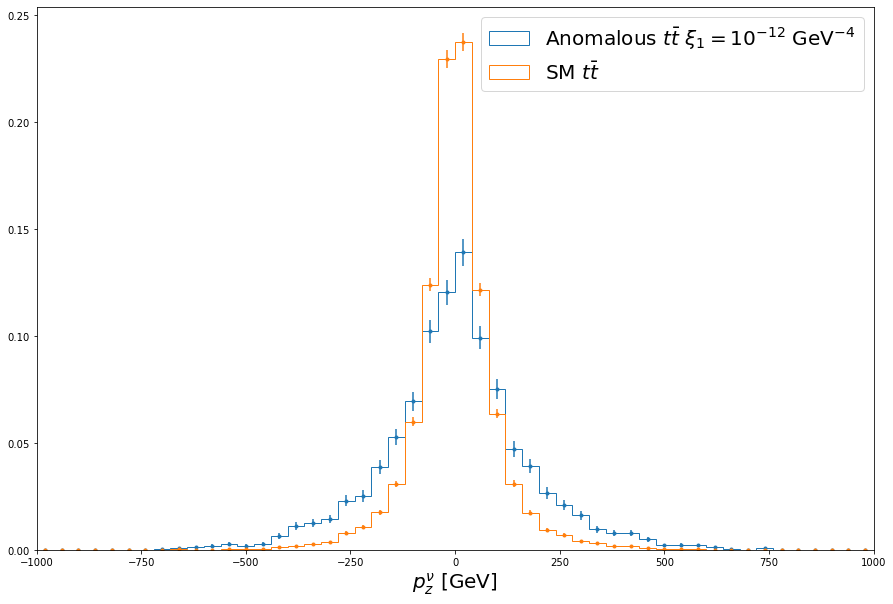

In [89]:
ax = plotWithRange([n.p3.z for n in xi1_1e12_presel["Neutrino"]],50,-1000,1000,r"$p_z^{\nu}$ [GeV]",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$",normalize=True)
plotWithRange([n.p3.z for n in SM_ttbar_presel["Neutrino"]],50,-1000,1000,r"$p_z^{\nu}$ [GeV]",r"SM $t\bar{t}$",ax,normalize=True)

<AxesSubplot:xlabel='$|1-\\frac{|\\phi^{t_1}-\\phi^{t_2}|}{\\pi}|$'>

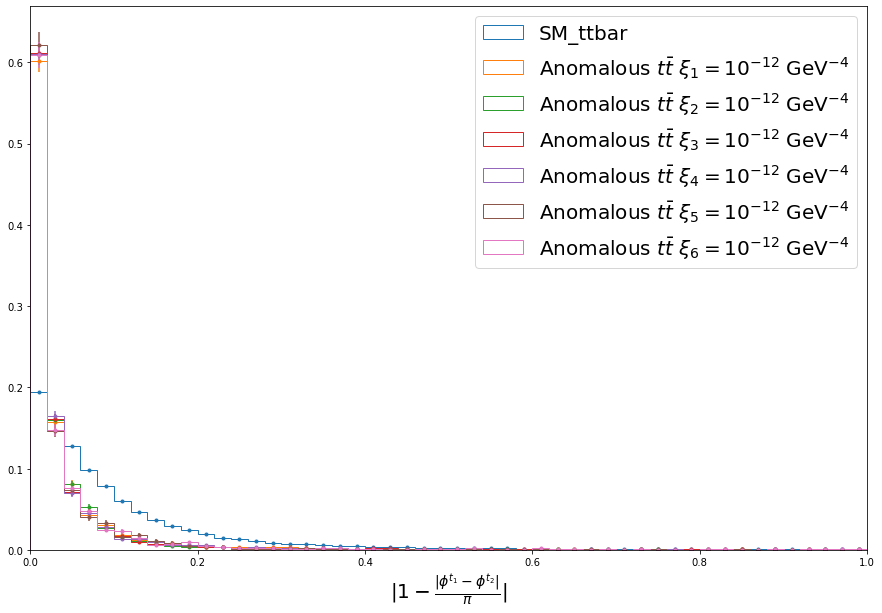

In [17]:
ax = plotWithRange([ np.abs(1-np.abs(t1.phi-t2.phi)/np.pi) for t1,t2 in zip(SM_ttbar_presel["top_1"],SM_ttbar_presel["top_2"])],50,0,1,"","SM_ttbar",normalize=True)
plotWithRange([ np.abs(1-np.abs(t1.phi-t2.phi)/np.pi) for t1,t2 in zip(xi1_1e12_presel["top_1"],xi1_1e12_presel["top_2"])],50,0,1,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)
plotWithRange([ np.abs(1-np.abs(t1.phi-t2.phi)/np.pi) for t1,t2 in zip(xi2_1e12_presel["top_1"],xi2_1e12_presel["top_2"])],50,0,1,"",r"Anomalous $t\bar{t}$ $\xi_2 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)
plotWithRange([ np.abs(1-np.abs(t1.phi-t2.phi)/np.pi) for t1,t2 in zip(xi3_1e12_presel["top_1"],xi3_1e12_presel["top_2"])],50,0,1,"",r"Anomalous $t\bar{t}$ $\xi_3 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)
plotWithRange([ np.abs(1-np.abs(t1.phi-t2.phi)/np.pi) for t1,t2 in zip(xi4_1e12_presel["top_1"],xi4_1e12_presel["top_2"])],50,0,1,"",r"Anomalous $t\bar{t}$ $\xi_4 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)
plotWithRange([ np.abs(1-np.abs(t1.phi-t2.phi)/np.pi) for t1,t2 in zip(xi5_1e12_presel["top_1"],xi5_1e12_presel["top_2"])],50,0,1,"",r"Anomalous $t\bar{t}$ $\xi_5 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)
plotWithRange([ np.abs(1-np.abs(t1.phi-t2.phi)/np.pi) for t1,t2 in zip(xi6_1e12_presel["top_1"],xi6_1e12_presel["top_2"])],50,0,1,r"$|1-\frac{|\phi^{t_1}-\phi^{t_2}|}{\pi}|$",r"Anomalous $t\bar{t}$ $\xi_6 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)


In [75]:
def acoplanarity_lowerThan(ds,par):
    return [np.abs(1-np.abs(t1.phi-t2.phi)/np.pi) < par for t1,t2 in zip(ds["top_1"],ds["top_2"])]

No BG events passed for par =  0.0 
Using 0.0001 as symbolic value
Maximum signal over square root of background: 45.6298751355512 for cut value: 0.01 (sig. eff.: 45.816618911174785 %, bg. rej. 90.5371041072667 %)
Closest point to 90% signal efficiency at cut value: 0.09 (sig. eff.: 89.77077363896848 %, bg. rej. 37.74370039300301 %)


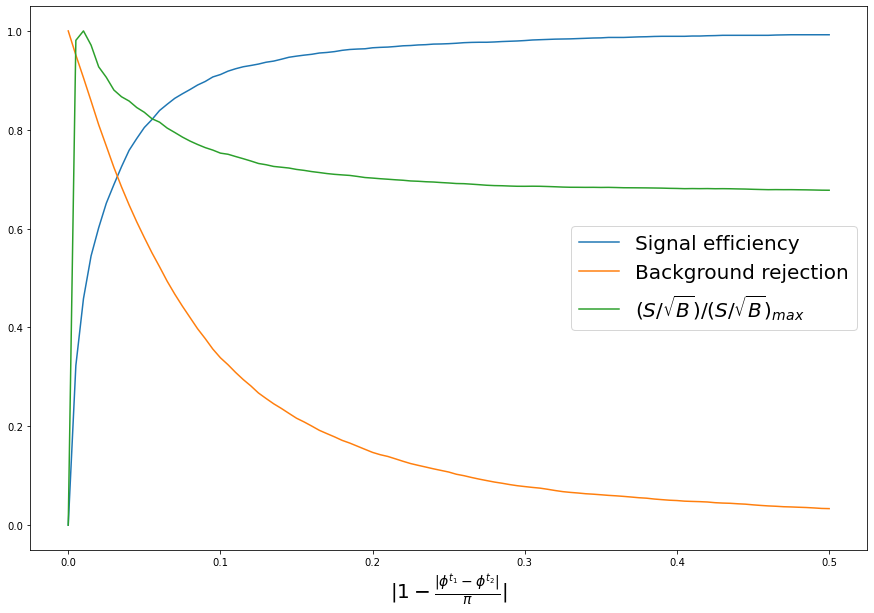

In [74]:
scanCut(xi1_1e12_presel,SM_ttbar_presel,acoplanarity_lowerThan,[0,0.5,0.5/100],r"$|1-\frac{|\phi^{t_1}-\phi^{t_2}|}{\pi}|$")

<AxesSubplot:xlabel='$p_T^{t_1}/p_T^{t_2}$'>

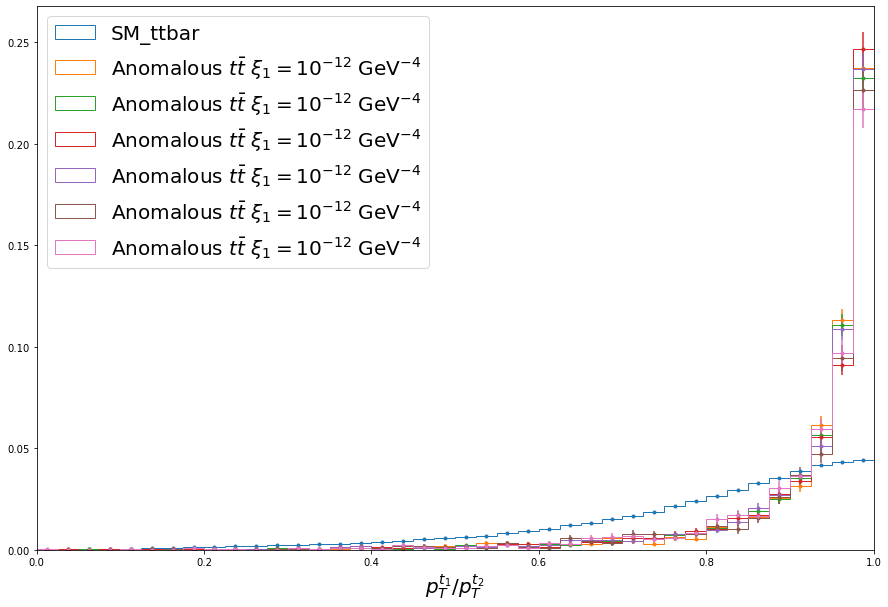

In [18]:
ax = plotWithRange([ (t1.pt/t2.pt) for t1,t2 in zip(SM_ttbar_presel["top_1"],SM_ttbar_presel["top_2"])],40,0,1,"","SM_ttbar",normalize=True)
plotWithRange([ (t1.pt/t2.pt) for t1,t2 in zip(xi1_1e12_presel["top_1"],xi1_1e12_presel["top_2"])],40,0,1,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)
plotWithRange([ (t1.pt/t2.pt) for t1,t2 in zip(xi2_1e12_presel["top_1"],xi2_1e12_presel["top_2"])],40,0,1,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)
plotWithRange([ (t1.pt/t2.pt) for t1,t2 in zip(xi3_1e12_presel["top_1"],xi3_1e12_presel["top_2"])],40,0,1,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)
plotWithRange([ (t1.pt/t2.pt) for t1,t2 in zip(xi4_1e12_presel["top_1"],xi4_1e12_presel["top_2"])],40,0,1,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)
plotWithRange([ (t1.pt/t2.pt) for t1,t2 in zip(xi5_1e12_presel["top_1"],xi5_1e12_presel["top_2"])],40,0,1,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)
plotWithRange([ (t1.pt/t2.pt) for t1,t2 in zip(xi6_1e12_presel["top_1"],xi6_1e12_presel["top_2"])],40,0,1,r"$p_T^{t_1}/p_T^{t_2}$",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)

In [76]:
def topPTbalance_higherThan(ds,par):
    return [(t1.pt/t2.pt) > par for t1,t2 in zip(ds["top_1"],ds["top_2"])]

Maximum signal over square root of background: 33.06823997857158 for cut value: 0.8800000000000003 (sig. eff.: 89.91404011461319 %, bg. rej. 30.607998767049395 %)
Closest point to 90% signal efficiency at cut value: 0.8800000000000003 (sig. eff.: 89.91404011461319 %, bg. rej. 30.607998767049395 %)


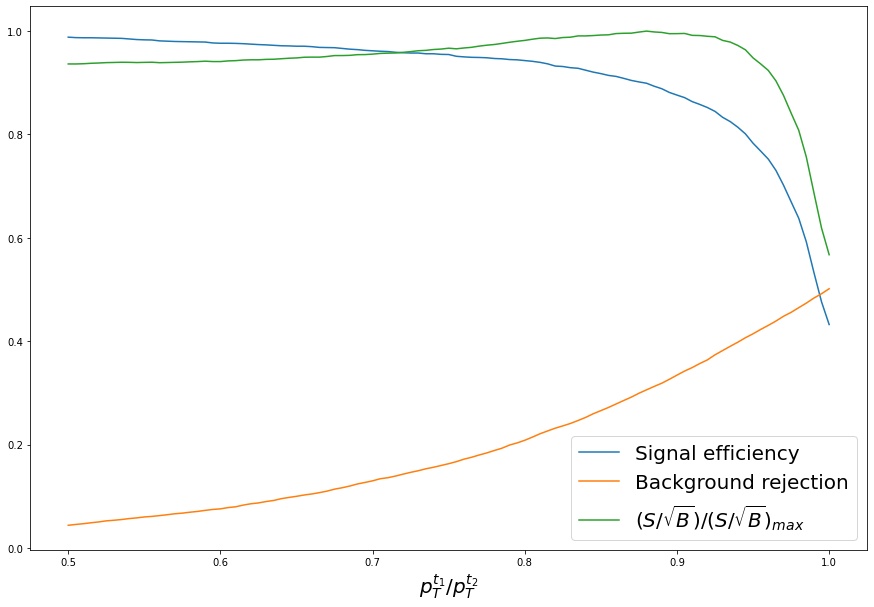

In [95]:
scanCut(xi1_1e12_presel,SM_ttbar_presel,topPTbalance_higherThan,[0.5,1,0.5/100],r"$p_T^{t_1}/p_T^{t_2}$")

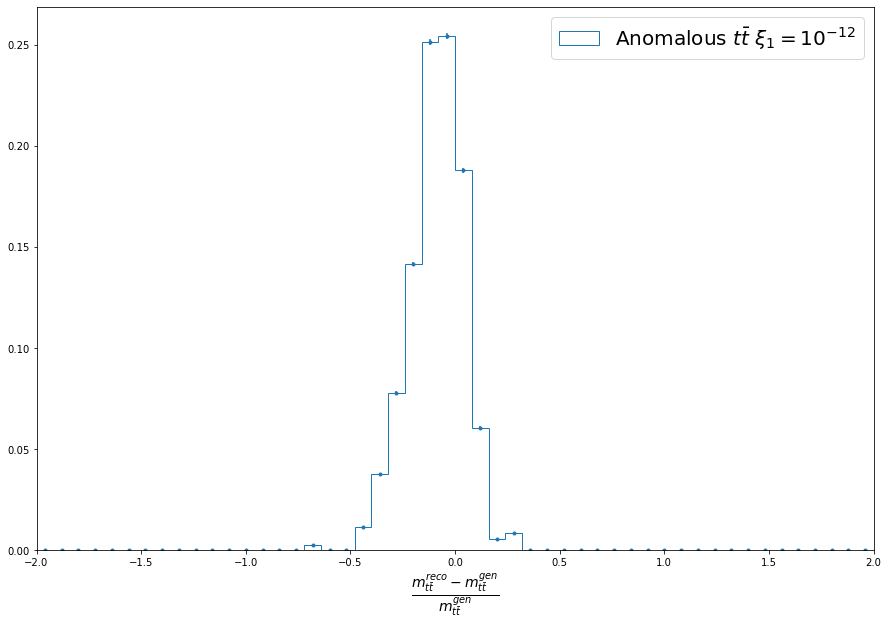

In [21]:
ax = plotWithRange((exampleSignal_1E12_semilep_presel_ds["m_ttbar"]-exampleSignal_1E12_semilep_presel_ds["gen_m_ttbar"])/exampleSignal_1E12_semilep_presel_ds["gen_m_ttbar"],50,-2,2,r"$\frac{m_{t\bar{t}}^{reco} - m_{t\bar{t}}^{gen}}{m_{t\bar{t}}^{gen}}$",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$",scalefactor=exampleSignal_1E12_sf)
#plotWithRange(exampleSignal_1E12_semilep_presel_ds["gen_m_ttbar"],50,0,2000,r"$m_{t\bar{t}}$ [GeV]","Generated mass",ax)

<AxesSubplot:xlabel='$m_{t\\bar{t}}$'>

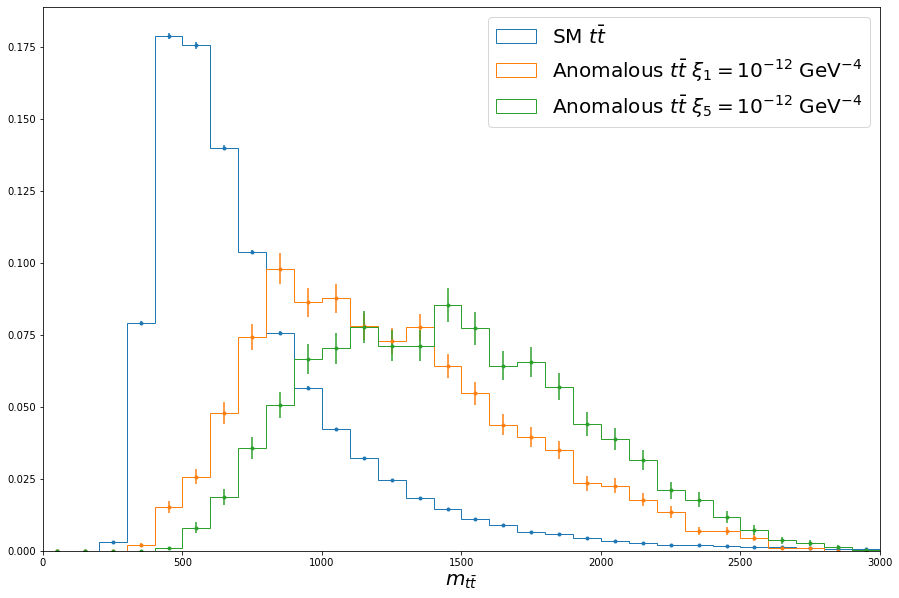

In [19]:
ax = plotWithRange(SM_ttbar_presel["m_ttbar"],30,0,3000,r"$m_{t\bar{t}}$ [GeV]",r"SM $t\bar{t}$",normalize=True)
plotWithRange(xi1_1e12_presel["m_ttbar"],30,0,3000,r"$m_{t\bar{t}}$",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)
#plotWithRange(xi2_1e12_presel["m_ttbar"],30,0,3000,r"$m_{t\bar{t}}$",r"Anomalous $t\bar{t}$ $\xi_2 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)
#plotWithRange(xi3_1e12_presel["m_ttbar"],30,0,3000,r"$m_{t\bar{t}}$",r"Anomalous $t\bar{t}$ $\xi_3 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)
#plotWithRange(xi4_1e12_presel["m_ttbar"],30,0,3000,r"$m_{t\bar{t}}$",r"Anomalous $t\bar{t}$ $\xi_4 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)
plotWithRange(xi5_1e12_presel["m_ttbar"],30,0,3000,r"$m_{t\bar{t}}$",r"Anomalous $t\bar{t}$ $\xi_5 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)
#plotWithRange(xi6_1e12_presel["m_ttbar"],30,0,3000,r"$m_{t\bar{t}}$",r"Anomalous $t\bar{t}$ $\xi_6 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)


In [77]:
def mtt_greaterThan(ds,par):
    return ds["m_ttbar"] > par

Maximum signal over square root of background: 46.59287814165407 for cut value: 960 (sig. eff.: 68.9971346704871 %, bg. rej. 79.417430839177 %)
Closest point to 90% signal efficiency at cut value: 720 (sig. eff.: 89.51289398280802 %, bg. rej. 60.42228558218387 %)


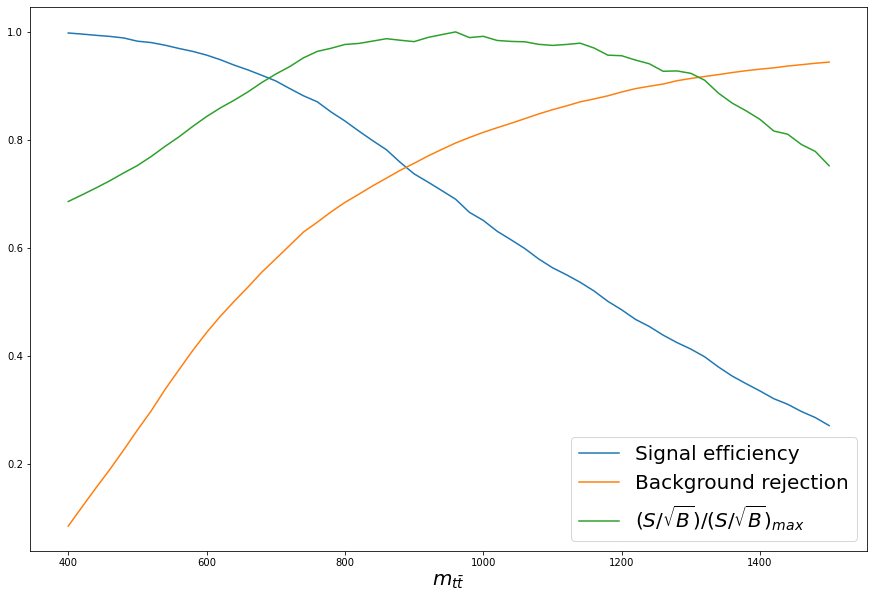

In [108]:
scanCut(xi1_1e12_presel,SM_ttbar_presel,mtt_greaterThan,[400,1500,20],r"$m_{t\bar{t}}$")

<AxesSubplot:xlabel='$p_T^{t_1}$ [GeV]'>

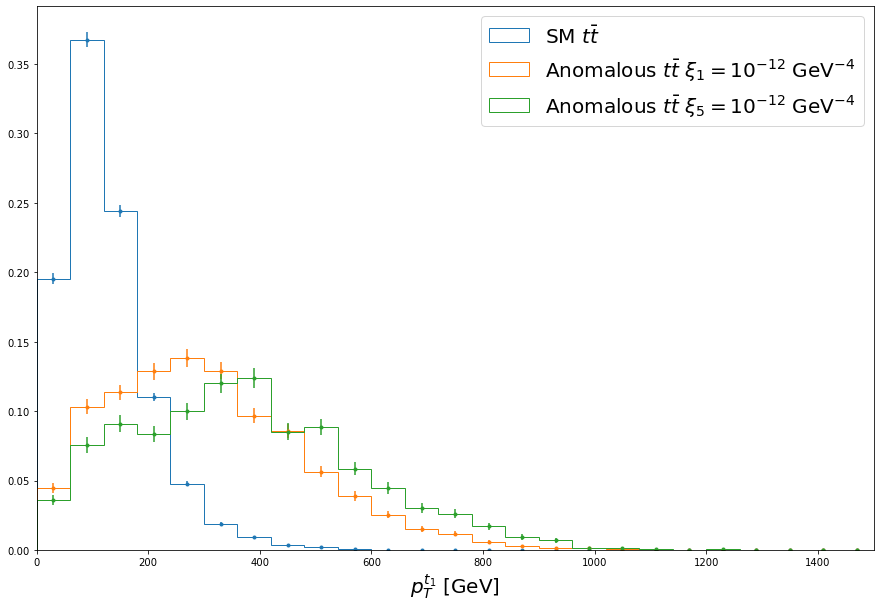

In [113]:
ax = plotWithRange([t.pt for t in SM_ttbar_presel["top_1"]],25,0,1500,"",r"SM $t\bar{t}$",normalize=True)
plotWithRange([t.pt for t in xi1_1e12_presel["top_1"]],25,0,1500,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)
plotWithRange([t.pt for t in xi5_1e12_presel["top_1"]],25,0,1500,"$p_T^{t_1}$ [GeV]",r"Anomalous $t\bar{t}$ $\xi_5 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)

In [78]:
def top1pt_greaterThan(ds,par):
    return [t.pt > par for t in ds["top_1"]] 

Maximum signal over square root of background: 89.41418540547208 for cut value: 425 (sig. eff.: 23.896848137535816 %, bg. rej. 99.32958310857671 %)
Closest point to 90% signal efficiency at cut value: 100 (sig. eff.: 89.054441260745 %, bg. rej. 44.501810896200965 %)


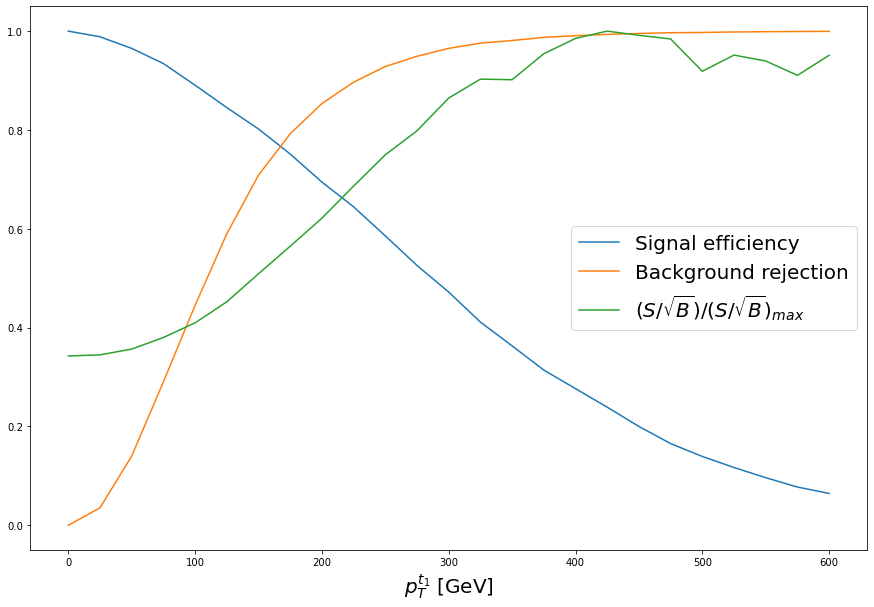

In [118]:
scanCut(xi1_1e12_presel,SM_ttbar_presel,top1pt_greaterThan,[0,600,25],r"$p_T^{t_1}$ [GeV]")

<AxesSubplot:xlabel='$p_T^{t_2}$ [GeV]'>

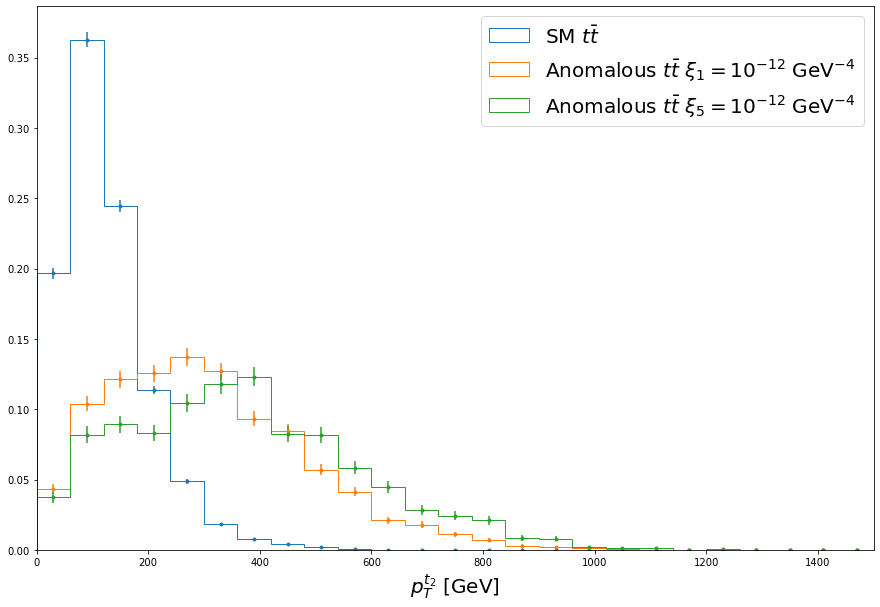

In [114]:
ax = plotWithRange([t.pt for t in SM_ttbar_presel["top_2"]],25,0,1500,"",r"SM $t\bar{t}$",normalize=True)
plotWithRange([t.pt for t in xi1_1e12_presel["top_2"]],25,0,1500,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)
plotWithRange([t.pt for t in xi5_1e12_presel["top_2"]],25,0,1500,r"$p_T^{t_2}$ [GeV]",r"Anomalous $t\bar{t}$ $\xi_5 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)

In [79]:
def top2pt_greaterThan(ds,par):
    return [t.pt > par for t in ds["top_2"]] 

Maximum signal over square root of background: 88.94763931483814 for cut value: 450 (sig. eff.: 20.229226361031518 %, bg. rej. 99.51452569931418 %)
Closest point to 90% signal efficiency at cut value: 100 (sig. eff.: 88.65329512893982 %, bg. rej. 44.35539801186715 %)


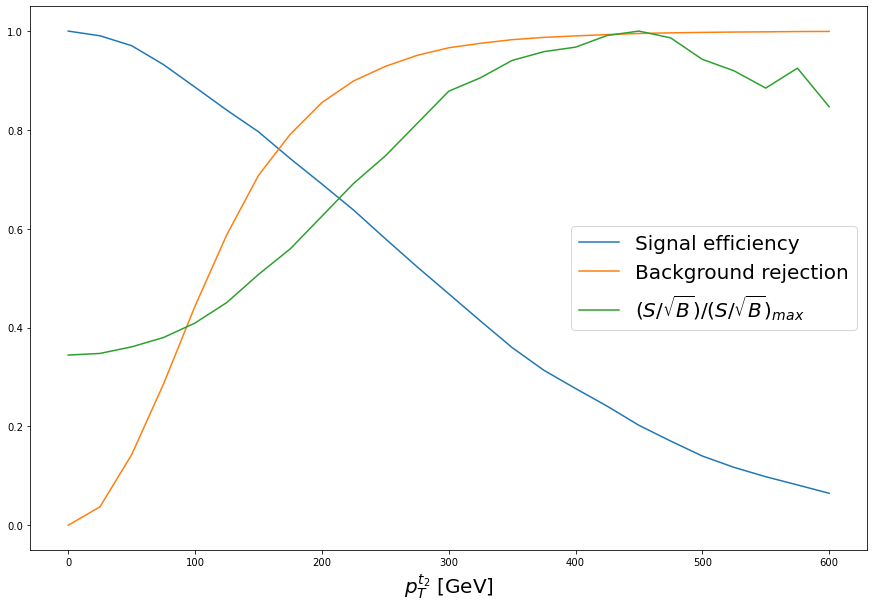

In [117]:
scanCut(xi1_1e12_presel,SM_ttbar_presel,top2pt_greaterThan,[0,600,25],r"$p_T^{t_2}$ [GeV]")

In [28]:
def HT_greaterThan(ds,par):
    return [l.pt + nu.pt + pt_j + pt_bj for l,nu,pt_j,pt_bj in zip(ds["Lepton"],ds["Neutrino"],ds["Jet_pt_tot"],ds["BJet_pt_tot"])] > par

Maximum signal over square root of background: 25.20389858446588 for cut value: 1100 (sig. eff.: 24.67048710601719 %, bg. rej. 99.25446554059234 %)
Closest point to 90% signal efficiency at cut value: 500 (sig. eff.: 88.22349570200572 %, bg. rej. 72.15265888125111 %)


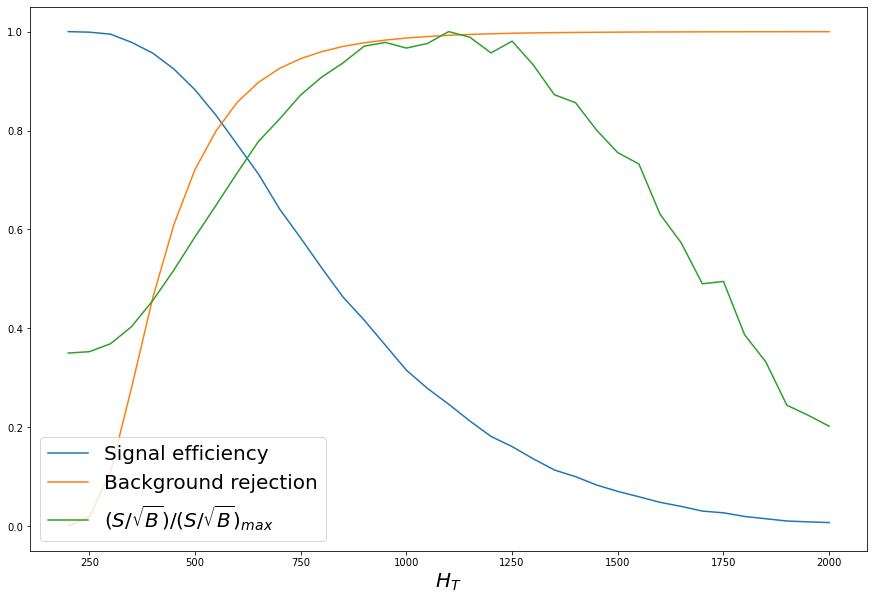

In [30]:
scanCut(xi1_1e12_presel,SM_ttbar_presel,HT_greaterThan,[200,2000,50],r"$H_T$")

<AxesSubplot:xlabel='$H_T$'>

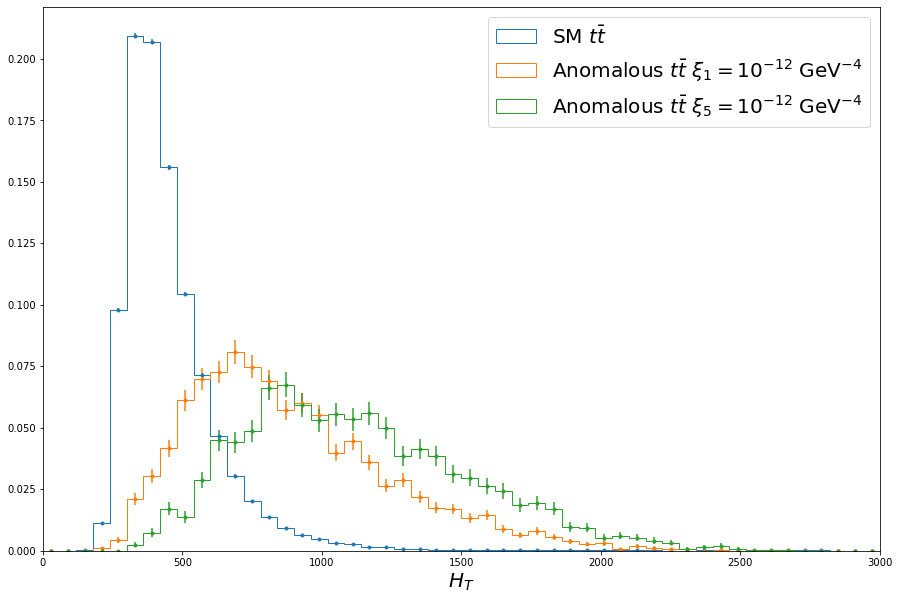

In [27]:
ax = plotWithRange([l.pt + nu.pt + pt_j + pt_bj for l,nu,pt_j,pt_bj in zip(SM_ttbar_presel["Lepton"],SM_ttbar_presel["Neutrino"],SM_ttbar_presel["Jet_pt_tot"],SM_ttbar_presel["BJet_pt_tot"])],50,0,3000,"",r"SM $t\bar{t}$",normalize=True)
plotWithRange([l.pt + nu.pt + pt_j + pt_bj for l,nu,pt_j,pt_bj in zip(xi1_1e12_presel["Lepton"],xi1_1e12_presel["Neutrino"],xi1_1e12_presel["Jet_pt_tot"],xi1_1e12_presel["BJet_pt_tot"])],50,0,3000,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)
plotWithRange([l.pt + nu.pt + pt_j + pt_bj for l,nu,pt_j,pt_bj in zip(xi5_1e12_presel["Lepton"],xi5_1e12_presel["Neutrino"],xi5_1e12_presel["Jet_pt_tot"],xi5_1e12_presel["BJet_pt_tot"])],50,0,3000,r"$H_T$",r"Anomalous $t\bar{t}$ $\xi_5 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)

In [ ]:
ax = plotWithRange([j.eta for j in exampleSignal_1E12_semilep_presel_ds["Jet_1"]],50,-5,5,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$")
plotWithRange([j.eta for j in exampleSignal_1E11_semilep_presel_ds["Jet_1"]],50,-5,5,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-11}$ GeV$^{-4}$",ax)
plotWithRange([j.eta for j in SM_ttbar_semilep_presel_ds["Jet_1"]],50,-5,5,r"$\eta_{j1}$","SM_ttbar",ax)

In [ ]:
ax = plotWithRange([j.eta for j in exampleSignal_1E12_semilep_presel_ds["Jet_2"]],50,-5,5,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$")
plotWithRange([j.eta for j in exampleSignal_1E11_semilep_presel_ds["Jet_2"]],50,-5,5,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-11}$ GeV$^{-4}$",ax)
plotWithRange([j.eta for j in SM_ttbar_semilep_presel_ds["Jet_2"]],50,-5,5,r"$\eta_{j2}$","SM $t\bar{t}$",ax)

In [ ]:
ax = plotWithRange([j.eta for j in exampleSignal_1E12_semilep_presel_ds["BJet_1"]],50,-5,5,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$")
plotWithRange([j.eta for j in exampleSignal_1E11_semilep_presel_ds["BJet_1"]],50,-5,5,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-11}$ GeV$^{-4}$",ax)
plotWithRange([j.eta for j in SM_ttbar_semilep_presel_ds["BJet_1"]],50,-5,5,r"$\eta_{Bj1}$","SM_ttbar",ax)

In [ ]:
ax = plotWithRange([j.eta for j in exampleSignal_1E12_semilep_presel_ds["BJet_2"]],50,-5,5,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$")
plotWithRange([j.eta for j in exampleSignal_1E11_semilep_presel_ds["BJet_2"]],50,-5,5,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-11}$ GeV$^{-4}$",ax)
plotWithRange([j.eta for j in SM_ttbar_semilep_presel_ds["BJet_2"]],50,-5,5,r"$\eta_{Bj2}$","SM_ttbar",ax)

In [ ]:
ax = plotWithRange(exampleSignal_1E12_semilep_presel_ds["m_ttbar"]-exampleSignal_1E12_semilep_presel_ds["m_protons"],50,-1000,1000,r"$\Delta m_{t\bar{t}}$",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$")
plotWithRange(exampleSignal_1E11_semilep_presel_ds["m_ttbar"]-exampleSignal_1E11_semilep_presel_ds["m_protons"],50,-1000,1000,r"$\Delta m_{t\bar{t}}$",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-11}$ GeV$^{-4}$",ax)
plotWithRange(SM_ttbar_semilep_presel_ds["m_ttbar"]-SM_ttbar_semilep_presel_ds["m_protons"],50,-1000,1000,r"$\Delta m_{t\bar{t}}$","SM_ttbar",ax)

In [ ]:
ax = plotWithRange(exampleSignal_1E12_semilep_presel_ds["y_ttbar"]-exampleSignal_1E12_semilep_presel_ds["y_protons"],50,-2.4,2.4,r"$\Delta y_{t\bar{t}}$",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$")
plotWithRange(exampleSignal_1E11_semilep_presel_ds["y_ttbar"]-exampleSignal_1E11_semilep_presel_ds["y_protons"],50,-2.4,2.4,r"$\Delta y_{t\bar{t}}$",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$",ax)
plotWithRange(SM_ttbar_semilep_presel_ds["y_ttbar"]-SM_ttbar_semilep_presel_ds["y_protons"],50,-2.4,2.4,r"$\Delta y_{t\bar{t}}$","SM_ttbar",ax)

In [ ]:
ax = plotWithRange([i[0] for i in exampleSignal_1E12_semilep_presel_ds["Jet.PT"]],50,0,2000,r"$m_{t\bar{t}}$",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$")
plotWithRange([i[0] for i in SM_ttbar_semilep_presel_ds["Jet.PT"]],50,0,2000,r"$p_{T}^{jet}$","SM_ttbar",ax)

In [ ]:
ax = plotWithRange(exampleSignal_1E12_semilep_presel_ds["BJet_energy_tot"],30,0,1000,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$")
plotWithRange(exampleSignal_1E11_semilep_presel_ds["BJet_energy_tot"],30,0,1000,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-11}$ GeV$^{-4}$",ax)
plotWithRange(SM_ttbar_semilep_presel_ds["BJet_energy_tot"],30,0,1000,r"$E_{BJets}^{tot}$","SM_ttbar",ax)

In [ ]:
ax = plotWithRange(exampleSignal_1E12_semilep_presel_ds["Jet_energy_tot"],30,0,1000,"","Anomalous_ttbar_1E12")
plotWithRange(exampleSignal_1E11_semilep_presel_ds["Jet_energy_tot"],30,0,1000,"","Anomalous_ttbar_1E11",ax)
plotWithRange(SM_ttbar_semilep_presel_ds["Jet_energy_tot"],30,0,1000,r"$E^{tot}_{Jets}$","SM_ttbar",ax)

In [ ]:
ax = plotWithRange(exampleSignal_1E12_semilep_presel_ds["BJet_pt_tot"],30,0,1000,"","Anomalous_ttbar_1E12")
plotWithRange(exampleSignal_1E11_semilep_presel_ds["BJet_pt_tot"],30,0,1000,"","Anomalous_ttbar_1E11",ax)
plotWithRange(SM_ttbar_semilep_presel_ds["BJet_pt_tot"],30,0,1000,r"BJets $P_{T}^{tot}$","SM_ttbar",ax)

In [ ]:
ax = plotWithRange(exampleSignal_1E12_semilep_presel_ds["Jet_pt_tot"],30,0,1000,"","Anomalous_ttbar_1E12")
plotWithRange(exampleSignal_1E11_semilep_presel_ds["Jet_pt_tot"],30,0,1000,"","Anomalous_ttbar_1E11",ax)
plotWithRange(SM_ttbar_semilep_presel_ds["Jet_pt_tot"],30,0,1000,r"Jets $P_T^{tot}$","SM_ttbar",ax)

In [ ]:
ax = plotWithRange(exampleSignal_1E12_semilep_presel_ds["Jet_pt_tot"]+exampleSignal_1E12_semilep_presel_ds["BJet_pt_tot"],30,0,1000,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$")
plotWithRange(exampleSignal_1E11_semilep_presel_ds["Jet_pt_tot"]+exampleSignal_1E11_semilep_presel_ds["BJet_pt_tot"],30,0,1000,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-11}$ GeV$^{-4}$",ax)
plotWithRange(SM_ttbar_semilep_presel_ds["Jet_pt_tot"]+SM_ttbar_semilep_presel_ds["BJet_pt_tot"],30,0,1000,r"$H_T$","SM_ttbar",ax)

In [92]:
def semilepAnalysisCentralSelection(dataset):

    ht_sel = HT_greaterThan(dataset,1100)    # GeV
    m_tt_sel = mtt_greaterThan(dataset,960) # GeV
    acop_sel = acoplanarity_lowerThan(dataset,0.09)
    ptbalance_sel = topPTbalance_higherThan(dataset,0.88)
    topPt1_sel = top1pt_greaterThan(dataset,425)
    topPt2_sel = top2pt_greaterThan(dataset,425)
    semilep_central_sel = ht_sel & m_tt_sel & acop_sel & ptbalance_sel & topPt1_sel & topPt2_sel
    frac_passing = 1.*np.count_nonzero(semilep_central_sel)/len(dataset["Jet.PT"])
    #print("Passing central selection:", np.count_nonzero(semilep_central_sel),"({:.2f}%)".format(100.*frac_passing))    

    for key in dataset:
        if key != 'n_before':
            dataset[key] = dataset[key][semilep_central_sel]
        
    return dataset

In [93]:
# perform central selection
signalPathTemplate = "/eos/home-a/abellora/SWAN_projects/TopPheno/FPMC_tools/DELPHES/{}/excl_anomTtbar_QED_skim_semilep_preselection.pickle"
signalPass_central = {}
for couplingSet,sampleIDs in tqdm(signalSampleDict.items(),desc='Signal samples'):
    sampleName = nameFromCouplingSet(couplingSet)
    signalPass_central[couplingSet] = runSelection(semilepAnalysisCentralSelection,signalPathTemplate,sampleIDs,suffix="_centralselection",sampleName=sampleName)

Signal samples:   0%|          | 0/12 [00:00<?, ?it/s]

Xi1=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi2=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi3=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi4=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi5=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi6=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi1=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Xi2=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Xi3=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Xi4=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Xi5=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Xi6=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

In [100]:
backgroundPathTemplate = "/eos/home-a/abellora/SWAN_projects/TopPheno/MadGraph/MG5_aMC_v3_1_0/{name}/Events/run_{id}/tag_1_delphes_events_skim_semilep_preselection.pickle"
backgroundPass_central = {}
for name,sampleIDs in tqdm(bgSampleDict.items(),desc='Background samples'):
    if "ttbar" in name:
        backgroundPass_central[name] = runSelection(semilepAnalysisCentralSelection,backgroundPathTemplate.format(name=name,id='{}'),sampleIDs,suffix="_centralselection",sampleName=name)
    else:
        backgroundPass_central[name] = runSelection(semilepAnalysisCentralSelection,backgroundPathTemplate.format(name=name,id='{}'),sampleIDs,suffix="_centralselection",sampleName=name)

Background samples:   0%|          | 0/2 [00:00<?, ?it/s]

SM_ttbar:   0%|          | 0/90 [00:00<?, ?it/s]

SM_WW:   0%|          | 0/46 [00:00<?, ?it/s]

Skipping sampleID: 11
Skipping sampleID: 39


In [28]:
signalPathTemplate = "/eos/home-a/abellora/SWAN_projects/TopPheno/FPMC_tools/DELPHES/{}/excl_anomTtbar_QED.root"
signalPass_central = {}
backgroundPathTemplate = "/eos/home-a/abellora/SWAN_projects/TopPheno/MadGraph/MG5_aMC_v3_1_0/{name}/Events/run_{id}/tag_1_delphes_events.root"
backgroundPass_central = {}

for couplingSet,sampleIDs in tqdm(signalSampleDict.items(),desc='Signal samples'):
    sampleName = nameFromCouplingSet(couplingSet)
    signalPass_central[couplingSet] = passedFraction(signalPathTemplate.replace('.root','_skim_semilep_preselection_centralselection.pickle'),sampleIDs=sampleIDs,sampleName=sampleName)
    
for name,sampleIDs in tqdm(bgSampleDict.items(),desc='Background samples'):
    backgroundPass_central[name] = passedFraction(backgroundPathTemplate.format(name=name,id='{}').replace('.root','_skim_semilep_preselection_centralselection.pickle'),sampleIDs=bgSampleDict[name],sampleName=name)

Signal samples:   0%|          | 0/12 [00:00<?, ?it/s]

Xi1=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi2=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi3=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi4=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi5=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi6=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi1=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Xi2=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Xi3=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Xi4=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Xi5=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Xi6=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Background samples:   0%|          | 0/2 [00:00<?, ?it/s]

SM_ttbar:   0%|          | 0/90 [00:00<?, ?it/s]

SM_WW:   0%|          | 0/46 [00:00<?, ?it/s]

Skipping sampleID: 11
Skipping sampleID: 39


In [102]:
signalPathTemplate = "/eos/home-a/abellora/SWAN_projects/TopPheno/FPMC_tools/DELPHES/{}/excl_anomTtbar_QED.root"
backgroundPathTemplate = "/eos/home-a/abellora/SWAN_projects/TopPheno/MadGraph/MG5_aMC_v3_1_0/{name}/Events/run_{id}/tag_1_delphes_events.root"

xi1_1e12_central = loadEvents(signalPathTemplate.replace('.root','_skim_semilep_preselection_centralselection.pickle'),sampleIDs=signalSampleDict[couplingSetFromName('Xi1=1e-12')])
xi2_1e12_central = loadEvents(signalPathTemplate.replace('.root','_skim_semilep_preselection_centralselection.pickle'),sampleIDs=signalSampleDict[couplingSetFromName('Xi2=1e-12')])
xi3_1e12_central = loadEvents(signalPathTemplate.replace('.root','_skim_semilep_preselection_centralselection.pickle'),sampleIDs=signalSampleDict[couplingSetFromName('Xi3=1e-12')])
xi4_1e12_central = loadEvents(signalPathTemplate.replace('.root','_skim_semilep_preselection_centralselection.pickle'),sampleIDs=signalSampleDict[couplingSetFromName('Xi4=1e-12')])
xi5_1e12_central = loadEvents(signalPathTemplate.replace('.root','_skim_semilep_preselection_centralselection.pickle'),sampleIDs=signalSampleDict[couplingSetFromName('Xi5=1e-12')])
xi6_1e12_central = loadEvents(signalPathTemplate.replace('.root','_skim_semilep_preselection_centralselection.pickle'),sampleIDs=signalSampleDict[couplingSetFromName('Xi6=1e-12')])
SM_ttbar_central = loadEvents(backgroundPathTemplate.format(name='SM_ttbar',id='{}').replace('.root','_skim_semilep_preselection_centralselection.pickle'),sampleIDs=bgSampleDict['SM_ttbar'])

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

<AxesSubplot:xlabel='$1 - \\frac{m_{t\\bar{t}}^{central}}{m_{t\\bar{t}}^{protons}}$'>

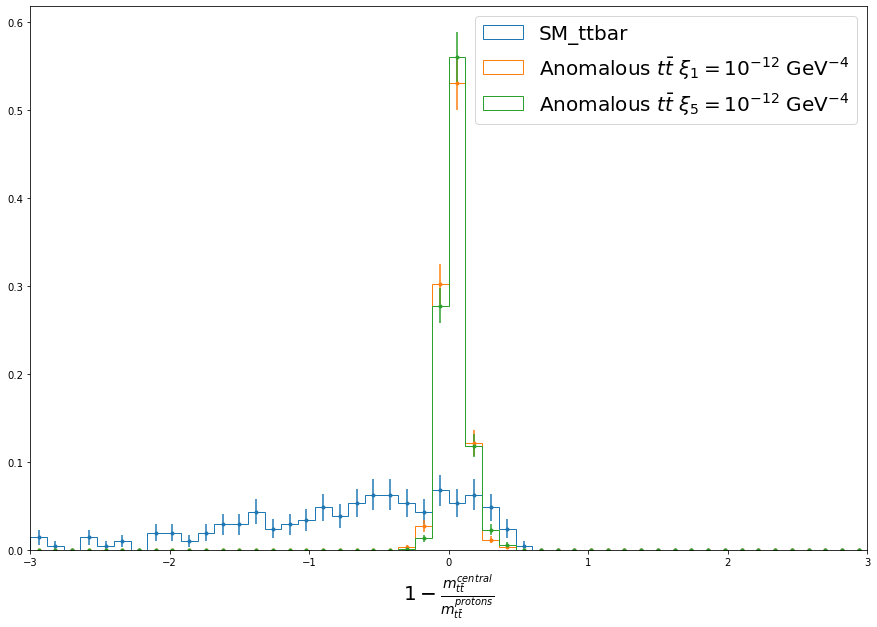

In [103]:
ax = plotWithRange(1 - SM_ttbar_central["m_ttbar"]/SM_ttbar_central["m_protons"],50,-3,3,"","SM_ttbar",normalize=True)
plotWithRange(1 - xi1_1e12_central["m_ttbar"]/xi1_1e12_central["m_protons"],50,-3,3,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)
plotWithRange(1 - xi5_1e12_central["m_ttbar"]/xi5_1e12_central["m_protons"],50,-3,3,r"$1 - \frac{m_{t\bar{t}}^{central}}{m_{t\bar{t}}^{protons}}$",r"Anomalous $t\bar{t}$ $\xi_5 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)

In [108]:
def absmassmatch_lowerThan(ds,par):
    return np.abs(1 - ds["m_ttbar"]/ds["m_protons"]) < par

No BG events passed for par =  0.0 
Using 0.0001 as symbolic value
Maximum signal over square root of background: 198.5 for cut value: 0.08 (sig. eff.: 67.0608108108108 %, bg. rej. 91.11111111111111 %)
Closest point to 90% signal efficiency at cut value: 0.16 (sig. eff.: 91.8918918918919 %, bg. rej. 82.22222222222221 %)


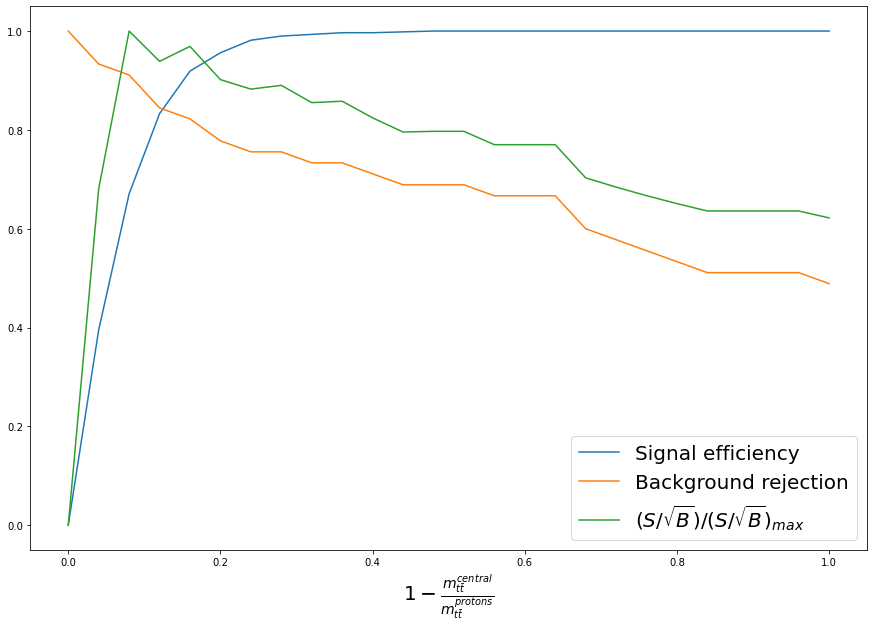

In [139]:
scanCut(xi1_1e12_central,SM_ttbar_central,absmassmatch_lowerThan,[0,1,1/25],r"$1 - \frac{m_{t\bar{t}}^{central}}{m_{t\bar{t}}^{protons}}$")

<AxesSubplot:xlabel='$\\Delta y_{t\\bar{t}}$'>

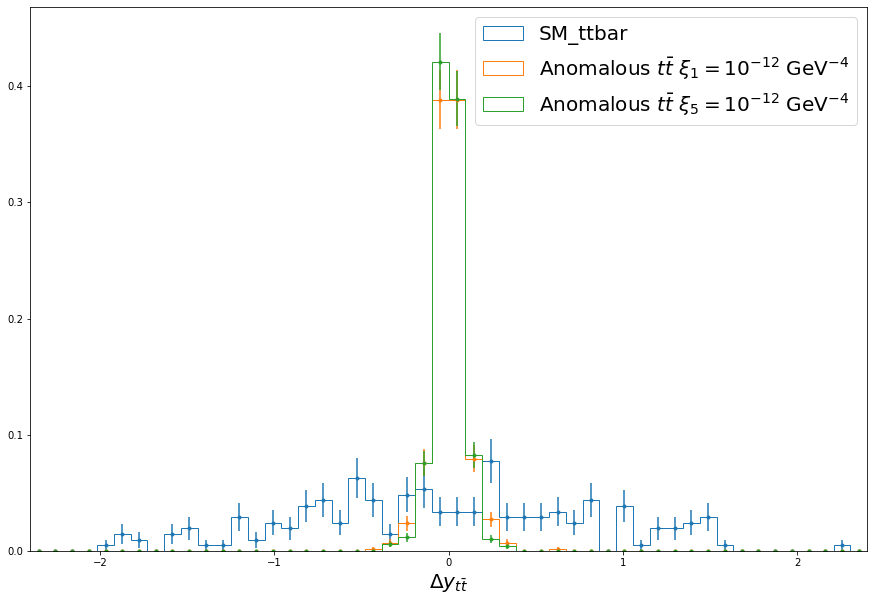

In [104]:
ax = plotWithRange(SM_ttbar_central["y_ttbar"]-SM_ttbar_central["y_protons"],50,-2.4,2.4,r"$\Delta y_{t\bar{t}}$","SM_ttbar",normalize=True)
plotWithRange(xi1_1e12_central["y_ttbar"]-xi1_1e12_central["y_protons"],50,-2.4,2.4,r"$\Delta y_{t\bar{t}}$",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)
plotWithRange(xi5_1e12_central["y_ttbar"]-xi5_1e12_central["y_protons"],50,-2.4,2.4,r"$\Delta y_{t\bar{t}}$",r"Anomalous $t\bar{t}$ $\xi_5 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)

In [107]:
def absdeltarapidity_lowerThan(ds,par):
    return np.abs(ds["y_ttbar"]-ds["y_protons"]) < par

No BG events passed for par =  0.0 
Using 0.0001 as symbolic value
Maximum signal over square root of background: 336.0 for cut value: 0.05 (sig. eff.: 56.75675675675676 %, bg. rej. 97.77777777777777 %)
Closest point to 90% signal efficiency at cut value: 0.15000000000000002 (sig. eff.: 89.3581081081081 %, bg. rej. 86.66666666666667 %)


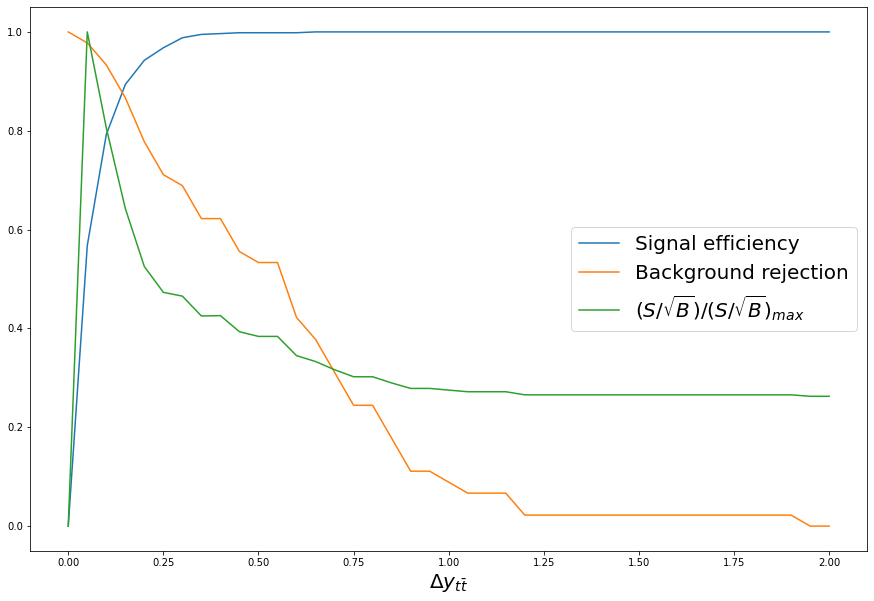

In [144]:
scanCut(xi1_1e12_central,SM_ttbar_central,absdeltarapidity_lowerThan,[0,2,0.05],r"$\Delta y_{t\bar{t}}$")

In [111]:
def semilepAnalysisProtonSelection(dataset):     
    mass_match_sel = absmassmatch_lowerThan(dataset,0.08) #GeV
    rapidity_match_sel = absdeltarapidity_lowerThan(dataset,0.05) #GeV
    semilep_proton_sel = mass_match_sel & rapidity_match_sel
    #frac_passing = 1.*np.count_nonzero(semilep_proton_sel)/len(dataset["Jet.PT"])
    #print("Passing proton selection:", np.count_nonzero(semilep_proton_sel),"({:.2f}%)".format(100.*frac_passing))    

    for key in dataset:
        if key != 'n_before':
            dataset[key] = dataset[key][semilep_proton_sel]
        
    return dataset

In [112]:
# perform central selection
signalPathTemplate = "/eos/home-a/abellora/SWAN_projects/TopPheno/FPMC_tools/DELPHES/{}/excl_anomTtbar_QED_skim_semilep_preselection_centralselection.pickle"
signalPass_proton = {}
for couplingSet,sampleIDs in tqdm(signalSampleDict.items(),desc='Signal samples'):
    sampleName = nameFromCouplingSet(couplingSet)
    signalPass_proton[couplingSet] = runSelection(semilepAnalysisProtonSelection,signalPathTemplate,sampleIDs,suffix="_protonselection",sampleName=sampleName)

Signal samples:   0%|          | 0/12 [00:00<?, ?it/s]

Xi1=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi2=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi3=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi4=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi5=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi6=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi1=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Xi2=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Xi3=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Xi4=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Xi5=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Xi6=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

In [27]:
backgroundPathTemplate = "/eos/home-a/abellora/SWAN_projects/TopPheno/MadGraph/MG5_aMC_v3_1_0/{name}/Events/run_{id}/tag_1_delphes_events_skim_semilep_preselection_centralselection.pickle"
backgroundPass_proton = {}
for name,sampleIDs in tqdm(bgSampleDict.items(),desc='Background samples'):
    if "ttbar" in name:
        backgroundPass_proton[name] = runSelection(semilepAnalysisProtonSelection,backgroundPathTemplate.format(name=name,id='{}'),sampleIDs,suffix="_protonselection",sampleName=name)
    else:
        backgroundPass_proton[name] = runSelection(semilepAnalysisProtonSelection,backgroundPathTemplate.format(name=name,id='{}'),sampleIDs,suffix="_protonselection",sampleName=name)

Background samples:   0%|          | 0/2 [00:00<?, ?it/s]

NameError: name 'semilepAnalysisProtonSelection' is not defined

In [30]:
signalPathTemplate = "/eos/home-a/abellora/SWAN_projects/TopPheno/FPMC_tools/DELPHES/{}/excl_anomTtbar_QED.root"
signalPass_proton = {}
backgroundPathTemplate = "/eos/home-a/abellora/SWAN_projects/TopPheno/MadGraph/MG5_aMC_v3_1_0/{name}/Events/run_{id}/tag_1_delphes_events.root"
backgroundPass_proton = {}

for couplingSet,sampleIDs in tqdm(signalSampleDict.items(),desc='Signal samples'):
    sampleName = nameFromCouplingSet(couplingSet)
    signalPass_proton[couplingSet] = passedFraction(signalPathTemplate.replace('.root','_skim_semilep_preselection_centralselection_protonselection.pickle'),sampleIDs=sampleIDs,sampleName=sampleName)
    
for name,sampleIDs in tqdm(bgSampleDict.items(),desc='Background samples'):
    backgroundPass_proton[name] = passedFraction(backgroundPathTemplate.format(name=name,id='{}').replace('.root','_skim_semilep_preselection_centralselection_protonselection.pickle'),sampleIDs=bgSampleDict[name],sampleName=name)

Signal samples:   0%|          | 0/12 [00:00<?, ?it/s]

Xi1=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi2=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi3=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi4=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi5=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi6=1e-12:   0%|          | 0/10 [00:00<?, ?it/s]

Xi1=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Xi2=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Xi3=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Xi4=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Xi5=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Xi6=1e-11:   0%|          | 0/10 [00:00<?, ?it/s]

Background samples:   0%|          | 0/2 [00:00<?, ?it/s]

SM_ttbar:   0%|          | 0/90 [00:00<?, ?it/s]

SM_WW:   0%|          | 0/46 [00:00<?, ?it/s]

Skipping sampleID: 11
Skipping sampleID: 39


In [47]:
from tabulate import tabulate
# cutflow tables
headers = ["Selection step"]
headers.extend([nameFromCouplingSet(cs) for cs in signalPass_presel])
expectedEvents = {cs : xSecDict[nameFromCouplingSet(cs)] * lumi_tot for cs in signalPass_presel}
tableValues = []
for sel_step in ["Pre-selection","Central selection","Proton matching"]:
    if sel_step == "Pre-selection":
        pass_dict = signalPass_presel
    elif sel_step == "Central selection":
        pass_dict = signalPass_central
    elif sel_step == "Proton matching":
        pass_dict = signalPass_proton
    # Update the expected events at each step
    for cs in expectedEvents:
        expectedEvents[cs] *= pass_dict[cs][1] / pass_dict[cs][0]
    tableValues.append([sel_step])
    tableValues[-1].extend(expectedEvents.values())
print("Expected Signal Events")
print(tabulate(tableValues,headers=headers,numalign="right"))

signalYields = expectedEvents

headers = ["Selection step"]
headers.extend([name for name in backgroundPass_presel])
expectedEvents = {name : xSecDict[name] * lumi_tot * protons_in_pps_weight for name in backgroundPass_presel}
tableValues = []
for sel_step in ["Pre-selection","Central selection","Proton matching"]:
    if sel_step == "Pre-selection":
        pass_dict = backgroundPass_presel
    elif sel_step == "Central selection":
        pass_dict = backgroundPass_central
    elif sel_step == "Proton matching":
        pass_dict = backgroundPass_proton
    # Update the expected events at each step
    for name in expectedEvents:
        expectedEvents[name] *= pass_dict[name][1] / pass_dict[name][0]
    tableValues.append([sel_step])
    tableValues[-1].extend(expectedEvents.values())
print("\n\nExpected Background Events")
print(tabulate(tableValues,headers=headers,numalign="right"))

backgroundYields = expectedEvents

Expected Signal Events
Selection step       Xi1=1e-12    Xi2=1e-12    Xi3=1e-12    Xi4=1e-12    Xi5=1e-12    Xi6=1e-12    Xi1=1e-11    Xi2=1e-11    Xi3=1e-11    Xi4=1e-11    Xi5=1e-11    Xi6=1e-11
-----------------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------
Pre-selection          1.00732      1.18323      1.05152      1.19431     0.871452     0.809881      106.331      118.911      105.182      116.615      88.6279      78.6721
Central selection      0.17087     0.178381      0.16799     0.166663     0.243401     0.232007      16.8194      17.8492      16.8764      17.2705      23.9088      21.1594
Proton matching      0.0756213    0.0811681    0.0738924    0.0745266     0.112718     0.103298      7.20008      8.26466      7.93336      7.86453      9.85928       8.8329


Expected Background Events
Selection step        SM_ttbar    SM_WW
-----------------  -----------  ------

In [53]:
backgroundYield = sum(backgroundYields.values())

In [54]:
def significance(signalYield,backgroundYield):
    return np.sqrt(2*(signalYield+backgroundYield)*np.log(1+signalYield/backgroundYield)-signalYield)

significances = {cs : significance(signalYield,backgroundYield) for cs,signalYield in signalYields.items()}

In [55]:
significances

{(1e-12, 0, 0, 0, 0, 0): 0.27511582418155145,
 (0, 1e-12, 0, 0, 0, 0): 0.285036292694292,
 (0, 0, 1e-12, 0, 0, 0): 0.2719498475879291,
 (0, 0, 0, 1e-12, 0, 0): 0.2731153980376983,
 (0, 0, 0, 0, 1e-12, 0): 0.33595804236864146,
 (0, 0, 0, 0, 0, 1e-12): 0.32159520735774005,
 (1e-11, 0, 0, 0, 0, 0): 2.7918667920600577,
 (0, 1e-11, 0, 0, 0, 0): 3.00745659955243,
 (0, 0, 1e-11, 0, 0, 0): 2.941612429613758,
 (0, 0, 0, 1e-11, 0, 0): 2.9277976422079033,
 (0, 0, 0, 0, 1e-11, 0): 3.3110458005768066,
 (0, 0, 0, 0, 0, 1e-11): 3.1180330836945203}